# **Understanding Urban Park Visitors’ Pattern in New York City and the Long-Standing Inequity Issues: A longitudinal Study with Fine-grained Human Mobility Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import json
import seaborn as sns

%matplotlib inline

In [2]:
path = "C:/Users/mchukwu/Desktop/sgpcore_newyork/extracted_monthly_patterns/extracted_monthly_patterns.csv"

In [3]:
with open(path,'rb') as f:
    df = pd.read_csv(f)

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df['poi_geoid'] = df['poi_cbg'].apply(lambda x: '{:.0f}'.format(x))

In [6]:
# check for null columns and drop them
threshold = int(0.8 * len(df))
df = df.dropna(axis=1,thresh=threshold)

In [7]:
list(df['city'].unique())

['New York']

In [7]:
def vertically_explode_json(df_, json_column='visitor_home_cbgs', key_col_name='visitor_home_cbg', value_col_name='cbg_visitor_count'):
    # This function vertically explodes a JSON column in SafeGraph Patterns
    # The resulting dataframe has one row for every data element in all the JSON of all the original rows
    # This is a slow step. If you are working with more than 20,000 rows you should explore faster implementations like pyspark
    #, see here: https://docs.safegraph.com/docs/faqs#section-how-do-i-work-with-the-patterns-columns-that-contain-json

    # Inputs
    #    df -- a pandas.DataFrame -- dataframe with a unique df.index for every row
    #    json_column -- each element of this column is a stringified json blog. No elements can be NULL. # TODO: convert NA JSON columns
    #to empty `{}` so function can handle them and just pass those rows through
    #    key_col_name -- arbitrary string, the name of the column in the output which contains the keys of the key:values of the JSON
    #    value_col_name -- arbitrary string, the name of the column in the output which contains the values of the key:values of the JSON
    # Outputs
    #    df -- a pandas.DataFrame with 2 new columns
    #    1) key_col_name
    #    2) value_col_name

    df = df_.copy()
    if(df.index.unique().shape[0] < df.shape[0]):
        raise("ERROR -- non-unique index found")
    df[json_column+'_dict'] = [json.loads(cbg_json) for cbg_json in df[json_column]]
    all_sgpid_cbg_data = [] # each cbg data point will be one element in this list
    for index, row in df.iterrows():
      # extract each key:value inside each visitor_home_cbg dict (2 nested loops)
      this_sgpid_cbg_data = [ {'orig_index' : index, key_col_name:key, value_col_name:value} for key,value in row[json_column+'_dict'].items() ]
      all_sgpid_cbg_data = all_sgpid_cbg_data + this_sgpid_cbg_data
    output = pd.DataFrame(all_sgpid_cbg_data)
    output.set_index('orig_index', inplace=True)
    return(output)

def explode_visitor_home_cbg(df, json_column='visitor_home_cbgs', key_col_name='visitor_home_cbg', value_col_name='cbg_visitor_count', keep_index=False):
    if(keep_index):
        df['index_original'] = df.index
    df = df.dropna(subset = [json_column]).copy() # Drop nan jsons
    df.reset_index(drop=True, inplace=True) # Every row must have a unique index
    df_exp = vertically_explode_json(df, json_column=json_column, key_col_name=key_col_name, value_col_name=value_col_name)
    df = df.merge(df_exp, left_index=True, right_index=True).reset_index(drop=True)
    return(df)


In [8]:
%%time
visitor_pattern = explode_visitor_home_cbg(df)

CPU times: total: 34.5 s
Wall time: 36.7 s


In [9]:
# filter to census code 36081|36047|36085|36061|36005
sgcore_df = visitor_pattern[(visitor_pattern['visitor_home_cbg'].str.match('36081|36047|36085|36061|36005') == True) & 
(visitor_pattern['location_name'].str.contains('Park|park|playground|Playground') == True)]

In [10]:
# drop visitor_count less than 5: SafeGraph applies noise to visit less than 5 as 4; that means if the actual visit is 1,2,3 or 4, SafeGraph
# records that as 4.
sgcore_df = sgcore_df[sgcore_df['cbg_visitor_count']>= 5]

In [11]:
cols_to_bring = [ 'date_range_start',
 'date_range_end',
 'placekey',
 'location_name',
 'latitude',
 'longitude',
 'poi_geoid',
 'visitor_home_cbg',
 'cbg_visitor_count',
 'raw_visit_counts',
 'raw_visitor_counts',
 'distance_from_home',
 'median_dwell','normalized_visits_by_total_visits']
sgcore_df = sgcore_df[cols_to_bring]

In [12]:
sgcore_df['visits_by_cbg'] = sgcore_df.apply(lambda x: round(x['cbg_visitor_count'] * (x['raw_visit_counts'] / x['raw_visitor_counts'])), axis=1)


In [13]:
sgcore_df.shape

(103638, 15)

### What is the nature of visits across CBGS in NYC?

In [14]:
pd.options.mode.chained_assignment = None 
## visualizing visits across CBGs

In [15]:
sgcoreV = sgcore_df.copy()

In [16]:
# Convert date_range_start and date_range_end to datetime

sgcoreV['date_range_start'] = pd.to_datetime(sgcoreV['date_range_start'])
sgcoreV['date_range_end'] = pd.to_datetime(sgcoreV['date_range_end'])


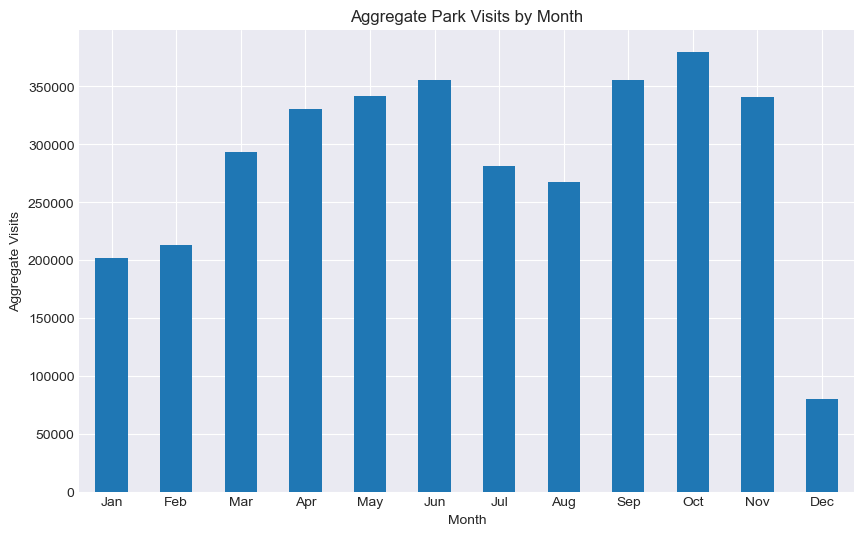

In [17]:
# Extract the month from 'date_range_start'
sgcoreV['month'] = sgcoreV['date_range_start'].dt.month

# Group the data by month and calculate the total number of visits for each month
monthly_visits = sgcoreV.groupby('month')['visits_by_cbg'].sum()
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(10, 6))
monthly_visits.plot(kind='bar')
plt.title('Aggregate Park Visits by Month')
plt.xlabel('Month')
plt.ylabel('Aggregate Visits')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
#plt.savefig('Aggregate Monthly Visits.png',dpi=600)

In [530]:
print(monthly_visits)

month
1     201937
2     213288
3     293364
4     330693
5     341581
6     355713
7     281495
8     267807
9     355530
10    380085
11    341173
12     80130
Name: visits_by_cbg, dtype: int64


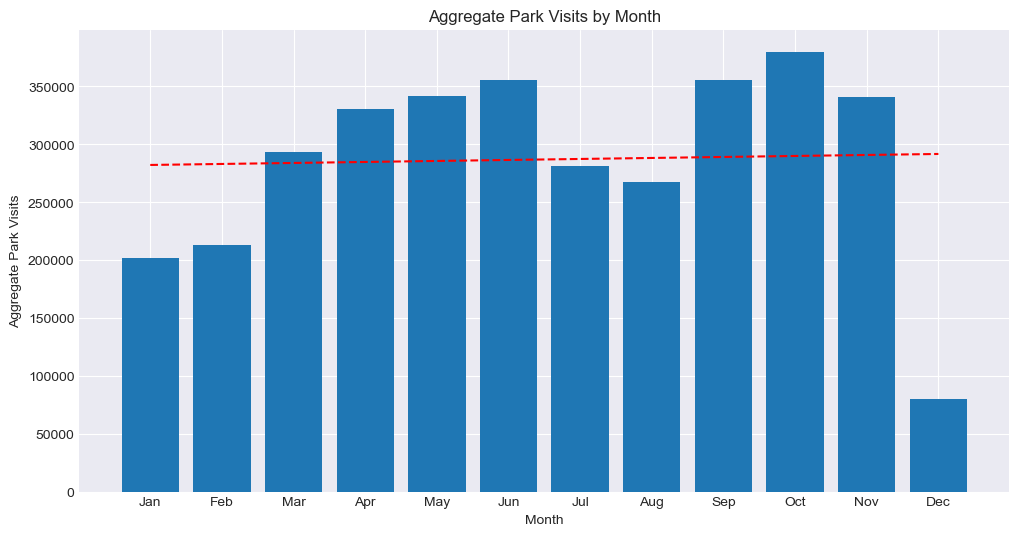

In [528]:
# Extract x and y values
x = sgcoreV['month'].unique()
y = sgcoreV.groupby('month')['visits_by_cbg'].sum()

# Fit a linear regression model
model = np.polyfit(x, y, 1)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xlabel('Month')
plt.ylabel('Aggregate Park Visits')
plt.title('Aggregate Park Visits by Month')

# Plot the trendline
plt.plot(x, model[0] * x + model[1], color='red', linestyle='--')
#plt.savefig('Aggregate_Park_Monthly_Visits_Trend.png',dpi=600)

In [19]:
# convert datetime to week to visualize weekly visits

sgcoreV['week'] = sgcoreV['date_range_start'].dt.dayofweek

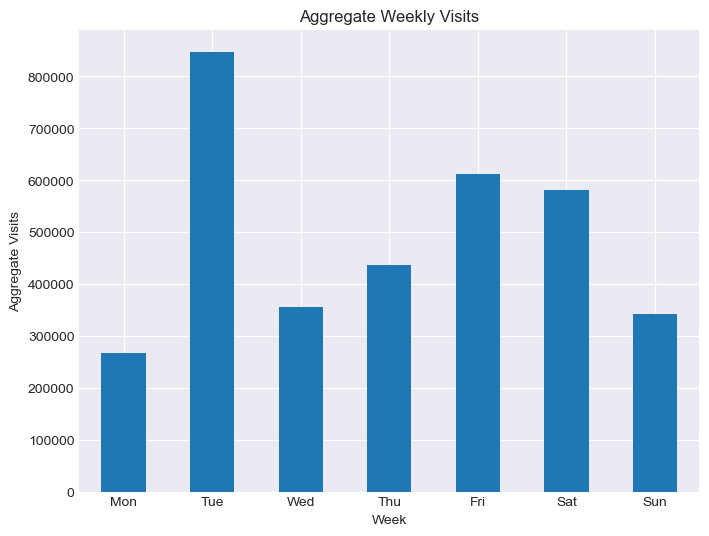

In [20]:
# Group the data by week and calculate the total number of visits for each week
weekly_visits = sgcoreV.groupby('week')['visits_by_cbg'].sum()
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(8, 6))
weekly_visits.plot(kind='bar')
plt.title('Aggregate Weekly Visits')
plt.xlabel('Week')
plt.ylabel('Aggregate Visits')
plt.xticks(ticks=range(0, 7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
#plt.savefig('Aggregate Park Weekly Visits.png',dpi=600)

In [531]:
print(weekly_visits)

week
0    267807
1    847825
2    355713
3    435660
4    612188
5    582022
6    341581
Name: visits_by_cbg, dtype: int64


## Group CBGs by Visits, Dwell Time, and Distance threshold

In [21]:
visit_per_cbg = sgcoreV.groupby('visitor_home_cbg')[['visits_by_cbg','median_dwell','distance_from_home']].sum()#.to_frame([['Frequency of Visits','median_dwell','distance_from_home']])
visit_per_cbg = pd.DataFrame(visit_per_cbg)

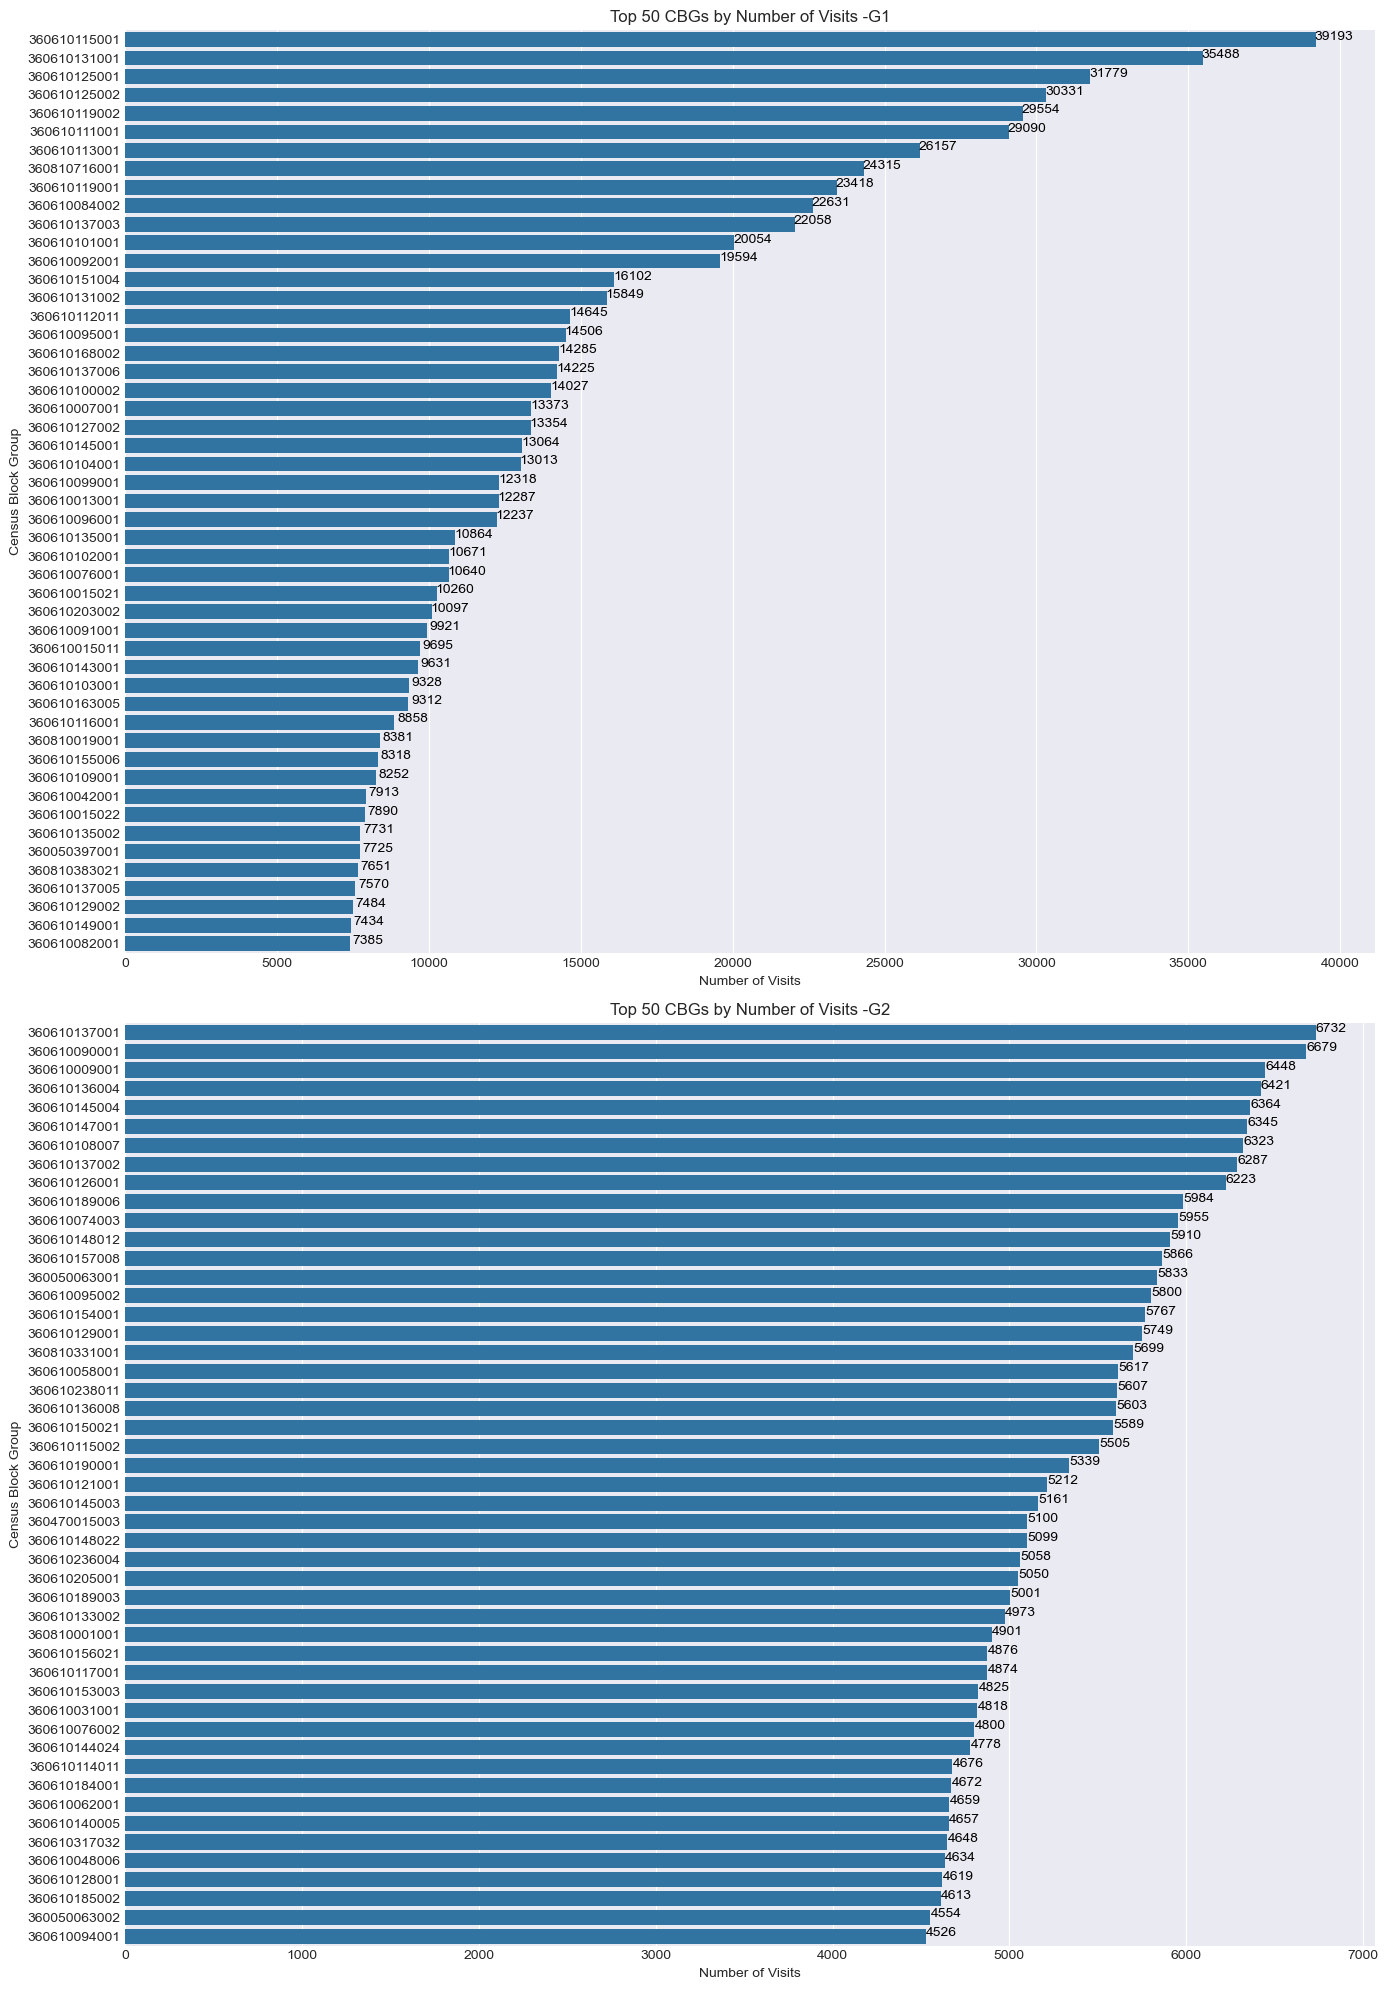

In [210]:
# Sort the DataFrame to get the top 20 and bottom 20 census block groups by the number of visits
third_50_visits = visit_per_cbg.sort_values('visits_by_cbg', ascending=False).head(50)
fourth_50_visits = visit_per_cbg.sort_values('visits_by_cbg', ascending=False).iloc[51:100]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 20))

# Plot the top 20 census blocks with most visits
sns.barplot(x='visits_by_cbg', y=third_50_visits.index, data=third_50_visits, ax=axes[0], orient='h')
axes[0].set_title('Top 50 CBGs by Number of Visits -G1')
axes[0].set_xlabel('Number of Visits')
axes[0].set_ylabel('Census Block Group')

# Add values inside the bars for the top 20
for index, value in enumerate(third_50_visits['visits_by_cbg']):
    axes[0].text(value + 600, index, f'{value}', color='black', ha="center")

# Plot the bottom 20 census blocks with least visits
sns.barplot(x='visits_by_cbg', y=fourth_50_visits.index, data=fourth_50_visits, ax=axes[1], orient='h')
axes[1].set_title('Top 50 CBGs by Number of Visits -G2')
axes[1].set_xlabel('Number of Visits')
axes[1].set_ylabel('Census Block Group')

# Add values inside the bars for the bottom 20
for index, value in enumerate(fourth_50_visits['visits_by_cbg']):
    axes[1].text(value + 90, index, f'{value}', color='black', ha="center")

# Adjust layout for better readability
plt.tight_layout()
#plt.savefig('Top 50 CBGs.png',dpi=300)

In [23]:
len(visit_per_cbg[visit_per_cbg['visits_by_cbg'] <=300])

2862

In [26]:
low_visitor_cbg = visit_per_cbg[visit_per_cbg['visits_by_cbg'] <=300]

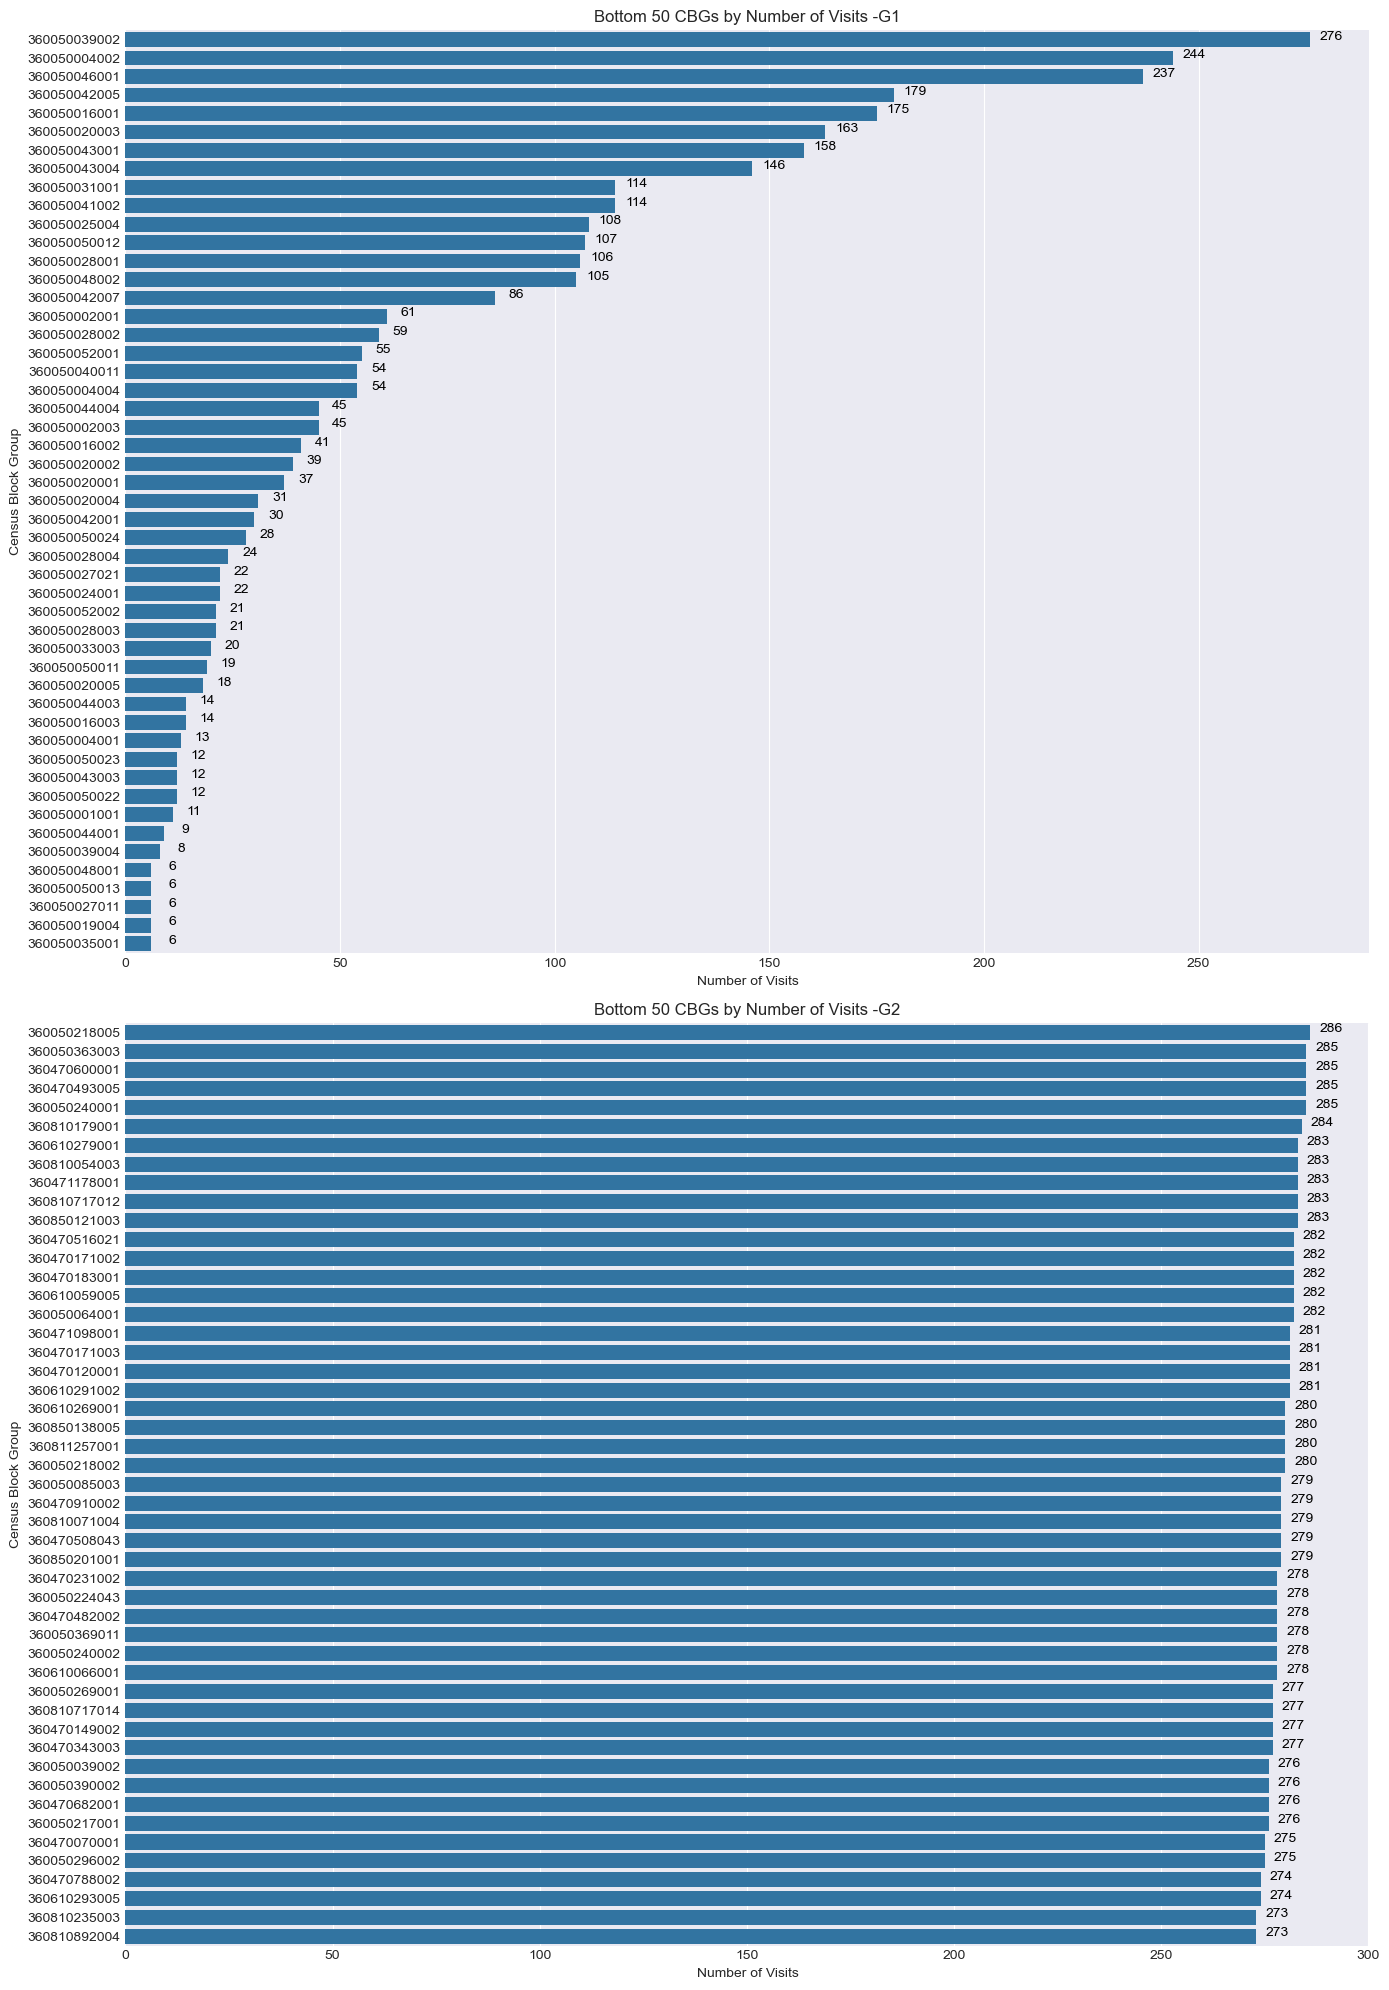

In [31]:
# Sort the DataFrame to get the top 20 and bottom 20 census block groups by the number of visits
low_visitor_cbg_first50 = low_visitor_cbg.head(50).sort_values(by='visits_by_cbg',ascending=False)
low_visitor_cbg_first50_100 = low_visitor_cbg.sort_values(by='visits_by_cbg',ascending=False).iloc[51:100]


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 20))

# Plot the top 20 census blocks with most visits
sns.barplot(x='visits_by_cbg', y=low_visitor_cbg_first50.index, data=low_visitor_cbg_first50, ax=axes[0], orient='h')
axes[0].set_title('Bottom 50 CBGs by Number of Visits -G1')
axes[0].set_xlabel('Number of Visits')
axes[0].set_ylabel('Census Block Group')

# Add values inside the bars for the top 20
for index, value in enumerate(low_visitor_cbg_first50['visits_by_cbg']):
    axes[0].text(value + 5, index, f'{value}', color='black', ha="center")

# Plot the bottom 20 census blocks with least visits
sns.barplot(x='visits_by_cbg', y=low_visitor_cbg_first50_100.index, data=low_visitor_cbg_first50_100, ax=axes[1], orient='h')
axes[1].set_title('Bottom 50 CBGs by Number of Visits -G2')
axes[1].set_xlabel('Number of Visits')
axes[1].set_ylabel('Census Block Group')

# Add values inside the bars for the bottom 20
for index, value in enumerate(low_visitor_cbg_first50_100['visits_by_cbg']):
    axes[1].text(value + 5, index, f'{value}', color='black', ha="center")

# Adjust layout for better readability
plt.tight_layout()
#plt.savefig('Bottom 50 CBGs.png',dpi=300)

## load socioeconomic data from census bureau (ACS 2018 -2022)

In [39]:
socio_df = pd.read_csv('socioeconomic.csv')

In [40]:
socio_df

,FIPS,per_capita_income,male,female,median_income,white,black,asian,others,15_17y,...,masters,prof_sch,doctorate,employed,unemployed,car,public_trans,walk,15mins,45mins
0,360010001001,36493.0,289,435,54050.0,351,212,25,15,7,...,34,19,19,317,27,184,61,8,81.85,11.85
1,360010001002,14825.0,720,815,33750.0,399,777,5,265,171,...,36,28,0,544,127,323,115,45,76.91,18.51
2,360010002011,33451.0,41,204,50481.0,37,174,0,0,0,...,14,0,0,129,0,82,47,0,63.57,17.83
3,360010002012,15049.0,819,618,17490.0,140,1125,72,0,61,...,78,78,34,660,124,358,210,0,68.84,27.46
4,360010002013,55546.0,459,324,85603.0,211,478,30,23,19,...,150,105,0,541,0,151,0,234,75.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16065,361231504005,34479.0,453,565,142000.0,1007,11,0,0,8,...,113,29,7,418,43,255,0,81,39.07,17.21
16066,361231505011,32759.0,574,1084,58583.0,1563,0,0,95,24,...,146,32,0,754,12,715,0,3,62.26,29.53
16067,361231505012,39596.0,331,344,78438.0,571,0,78,26,48,...,53,13,13,385,6,290,0,40,61.43,0.00
16068,361231505021,36082.0,919,893,67083.0,1796,2,0,0,145,...,100,24,3,722,32,475,2,27,58.01,8.43


In [41]:
# convert FIPS from int to text data type
socio_df['FIPS'] = socio_df['FIPS'].astype(str)

In [42]:
# filter to location in New york city: Bronx, Queens, Kings, Brooklyn, Staten Island
socio_df = socio_df[socio_df['FIPS'].str.match('36085|36047|36081|36061|36005')]

In [43]:
# drop rows with NAN
socio_df = socio_df.dropna()

In [44]:
socio_df

,FIPS,per_capita_income,male,female,median_income,white,black,asian,others,15_17y,...,masters,prof_sch,doctorate,employed,unemployed,car,public_trans,walk,15mins,45mins
289,360050002001,32210.0,693,517,123208.0,257,508,43,296,46,...,185,52,36,506,0,353,116,37,88.74,30.24
290,360050002002,39257.0,1100,1011,115764.0,169,784,32,875,0,...,337,0,0,1143,65,457,376,185,96.68,51.79
291,360050002003,27074.0,762,787,81622.0,324,181,224,686,39,...,149,0,0,663,43,274,371,0,100.00,81.24
294,360050004002,26913.0,728,676,71230.0,59,396,8,862,59,...,0,0,0,718,44,421,247,0,91.36,42.34
295,360050004003,42310.0,1751,1798,129469.0,362,1084,155,1374,305,...,389,71,0,1553,223,870,491,0,96.21,46.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12867,360850319012,29070.0,663,584,93547.0,182,430,200,78,109,...,170,0,0,629,16,335,206,40,93.57,56.68
12869,360850319021,18196.0,404,751,17052.0,368,592,10,69,90,...,55,0,0,372,12,143,189,0,100.00,44.71
12870,360850319022,37295.0,845,1000,160500.0,191,1283,100,133,147,...,126,0,0,924,11,438,441,34,94.09,51.70
12871,360850319023,31366.0,1185,868,125217.0,393,717,107,580,153,...,60,0,0,956,32,679,206,41,74.62,25.38


In [608]:
#list(socio_df)

In [46]:
# regroup education to low_education, high_education, elderly

#socio_df['low_edu'] = socio_df[['less_high_sch', 'high_sch']].sum(axis=1)
#socio_df['high_edu'] = socio_df[['some_college', 'bachelor', 'masters', 'prof_sch', 'doctorate']].sum(axis=1)
socio_df['young'] = socio_df[['15_17y', '18_24y', '25_34y']].sum(axis=1)
socio_df['adult'] = socio_df[['35_44y', '35_44y', '55_64y']].sum(axis=1)
socio_df['elderly'] = socio_df[['65_74y', '75_84y', '85y+']].sum(axis=1)

In [47]:
socio_df['tot_sex'] = socio_df[['male','female']].sum(axis=1)
socio_df['tot_pop'] = socio_df[['white','black','asian','others']].sum(axis=1)
socio_df['tot_age'] = socio_df[['elderly','young','adult']].sum(axis=1)
socio_df['tot_unemp'] = socio_df[['employed','unemployed']].sum(axis=1)
socio_df['tot_commute'] = socio_df[['15mins','45mins']].sum(axis=1)
socio_df['tot_transport'] = socio_df[['car','public_trans','walk']].sum(axis=1)
socio_df['tot_edu'] = socio_df[['less_high_sch','high_sch']].sum(axis=1)

In [48]:
# calculate percent for race, education, transportation,traveltime

socio_df['pct_male'] = (socio_df['male'] / socio_df['tot_sex']*100).round(2)
socio_df['pct_female'] = (socio_df['female'] / socio_df['tot_sex']*100).round(2)
socio_df['pct_white'] = (socio_df['white'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_black'] = (socio_df['black'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_asian'] = (socio_df['asian'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_others'] = (socio_df['others'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_young'] = (socio_df['young'] / socio_df['tot_age']*100).round(2)
socio_df['pct_adult'] = (socio_df['adult'] / socio_df['tot_age']*100).round(2)
socio_df['pct_elderly'] = (socio_df['elderly'] / socio_df['tot_age']*100).round(2)
socio_df['pct_low_edu'] = (socio_df['less_high_sch'] / socio_df['tot_edu']*100).round(2)
socio_df['pct_high_edu'] = (socio_df['high_sch'] / socio_df['tot_edu']*100).round(2)
socio_df['pct_short_comute'] = (socio_df['15mins'] / socio_df['tot_commute']*100).round(2)
socio_df['pct_long_comute'] = (socio_df['45mins'] / socio_df['tot_commute']*100).round(2)
socio_df['pct_unemp'] = (socio_df['unemployed'] / socio_df['tot_unemp']*100).round(2)
socio_df['pct_emp'] = (socio_df['employed'] / socio_df['tot_unemp']*100).round(2)
socio_df['pct_car'] = (socio_df['car'] / socio_df['tot_transport']*100).round(2)
socio_df['pct_public_trans'] = (socio_df['public_trans'] / socio_df['tot_transport']*100).round(2)
socio_df['pct_0car'] = (socio_df['walk'] / socio_df['tot_transport']*100).round(2)

In [49]:
socio_df_copy = socio_df.copy()

In [50]:
# Define income thresholds (reference: Census Bureau and Poverty Tracker)
Median_income = 81000

socio_df_copy['pct_low_income'] = (socio_df_copy['median_income'] < Median_income).astype(int)
socio_df_copy['pct_high_income'] = (socio_df_copy['median_income'] >= Median_income).astype(int)

In [51]:
socio_df_1 = socio_df_copy.copy()

In [52]:
socio_df_1 = socio_df_1[['FIPS','per_capita_income','median_income','pct_male','pct_female','pct_white','pct_black',
        'pct_asian','pct_others','pct_low_edu', 'pct_high_edu','pct_young','pct_adult', 'pct_elderly',
       'pct_short_comute', 'pct_long_comute', 'pct_car', 'pct_public_trans',
       'pct_0car','pct_unemp', 'pct_emp', 'pct_low_income', 'pct_high_income']]

In [53]:
socio_df_1[['pct_low_income', 'pct_high_income']]

,pct_low_income,pct_high_income
289,0,1
290,0,1
291,0,1
294,1,0
295,0,1
...,...,...
12867,0,1
12869,1,0
12870,0,1
12871,0,1


In [54]:
# merge safegraph data with socio_df_1 data

merged_df = socio_df_1.merge(visit_per_cbg,left_on='FIPS',right_on='visitor_home_cbg')#.drop('visitor_home_cbg',axis=1)

In [55]:
merged_df = merged_df.groupby('FIPS').first().reset_index()

In [56]:
merged_df

,FIPS,per_capita_income,median_income,pct_male,pct_female,pct_white,pct_black,pct_asian,pct_others,pct_low_edu,...,pct_car,pct_public_trans,pct_0car,pct_unemp,pct_emp,pct_low_income,pct_high_income,visits_by_cbg,median_dwell,distance_from_home
0,360050002001,32210.0,123208.0,57.27,42.73,23.28,46.01,3.89,26.81,15.53,...,69.76,22.92,7.31,0.00,100.00,0,1,61,9.0,195331.0
1,360050002002,39257.0,115764.0,52.11,47.89,9.09,42.15,1.72,47.04,17.74,...,44.89,36.94,18.17,5.38,94.62,0,1,370,128.0,751613.0
2,360050002003,27074.0,81622.0,49.19,50.81,22.90,12.79,15.83,48.48,10.21,...,42.48,57.52,0.00,6.09,93.91,0,1,45,6.0,174630.0
3,360050004002,26913.0,71230.0,51.85,48.15,4.45,29.89,0.60,65.06,14.31,...,63.02,36.98,0.00,5.77,94.23,1,0,244,159.0,572192.0
4,360050004003,42310.0,129469.0,49.34,50.66,12.17,36.44,5.21,46.18,24.10,...,63.92,36.08,0.00,12.56,87.44,0,1,1461,1504.0,1545405.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,360850319012,29070.0,93547.0,53.17,46.83,20.45,48.31,22.47,8.76,37.98,...,57.66,35.46,6.88,2.48,97.52,0,1,381,434.0,54804.0
3800,360850319021,18196.0,17052.0,34.98,65.02,35.42,56.98,0.96,6.64,33.89,...,43.07,56.93,0.00,3.12,96.88,1,0,234,384.0,36981.0
3801,360850319022,37295.0,160500.0,45.80,54.20,11.19,75.16,5.86,7.79,13.86,...,47.97,48.30,3.72,1.18,98.82,0,1,429,404.0,250813.0
3802,360850319023,31366.0,125217.0,57.72,42.28,21.87,39.90,5.95,32.28,18.61,...,73.33,22.25,4.43,3.24,96.76,0,1,188,374.0,62975.0


#             PART TWO

## Statistical Analysis

# Does socioeconomic factors contribute to park visits in NYC?

#### RANK CBGs into 3 groups Based on Socioeconomic/demographic variables

### 1) Income category

In [1234]:
merged_income = merged_df[['FIPS','median_income','visits_by_cbg']]

In [1235]:
# Rank median_income and create 3 CBGs based on this

merged_income_ranked = merged_income.sort_values('median_income')

In [1236]:
#merged_income_ranked

In [1237]:
# group the CBGS now: Assign first 1268 CBGs as pct_low, second CBGs as pct_median and 3rd CBGs as pct_high income

pct_low_income = merged_income_ranked.head(1267)

In [1238]:
pct_median_income = merged_income_ranked.iloc[1267:2535]

In [1239]:
pct_high_income = merged_income_ranked.iloc[2536:3804]

In [1240]:
# perform ANOVA Test for visits between these groups

### Import ANOVA Stats Library

In [1241]:
import scipy
from scipy.stats import shapiro, levene
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [1242]:
## check ANOVA assumption

# 1) normality test 
# 2) test for equal variance

# Normality test
statistic, p_value = shapiro(pct_low_income)
print("Shapiro-Wilk test for income category:", statistic, p_value)

# Homogeneity of variances test
statistic, p_value = levene(pct_low_income['visits_by_cbg'], pct_median_income['visits_by_cbg'],pct_high_income['visits_by_cbg'])
print("Levene's test:", statistic, p_value)

Shapiro-Wilk test for income category: 0.5952931248105514 2.1257531544083896e-69
Levene's test: 30.868689120324568 5.0307833520773905e-14


In [1243]:
# perform One_way ANOVA

anova_result_income= f_oneway(pct_low_income['visits_by_cbg'], pct_median_income['visits_by_cbg'],pct_high_income['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 32.020500334710974
ANOVA p-value: 1.620146132063281e-14


In [1244]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_income = pct_low_income['visits_by_cbg'].mean()
pct_mean_visits_median_income = pct_median_income['visits_by_cbg'].mean()
pct_mean_visits_high_income = pct_high_income['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_income: {pct_mean_visits_low_income}')
print(f'Mean visits for pct_medium_income: {pct_mean_visits_median_income}')
print(f'Mean visits for pct_high_income: {pct_mean_visits_high_income}')

Mean visits for pct_low_income: 520.9060773480663
Mean visits for pct_medium_income: 513.8730283911672
Mean visits for pct_high_income: 1046.0181388012618


In [1245]:
# Step 1: Combine data into a single DataFrame
combined_data = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_income['visits_by_cbg'], 
        pct_median_income['visits_by_cbg'], 
        pct_high_income['visits_by_cbg']
    ], ignore_index=True),
    'income_group': ['pct_low_income'] * len(pct_low_income) + 
                    ['pct_median_income'] * len(pct_median_income) + 
                    ['pct_high_income'] * len(pct_high_income)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data['visits_by_cbg'],
                                  groups=combined_data['income_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1           group2       meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------
pct_high_income    pct_low_income -525.1121    0.0 -703.9875 -346.2366   True
pct_high_income pct_median_income -532.1451    0.0 -710.9853  -353.305   True
 pct_low_income pct_median_income    -7.033 0.9953 -185.9085  171.8424  False
-----------------------------------------------------------------------------


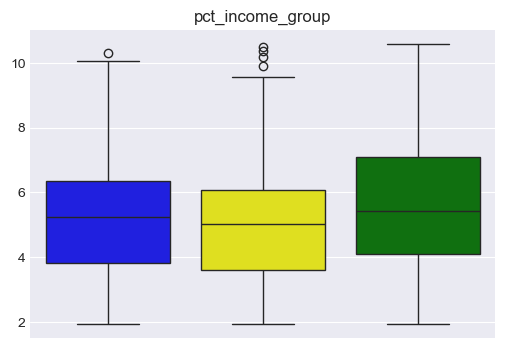

In [1246]:
# Apply log transformation to the visits_by_cbg column
combined_data['log_visits_by_cbg'] = np.log(combined_data['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
income_palette = {'pct_low_income': 'blue', 'pct_median_income': 'yellow', 'pct_high_income': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='income_group', y='log_visits_by_cbg', data=combined_data, palette=income_palette,hue='income_group')
plt.title('pct_income_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_income_group.png',dpi=300)

### 2) Race Black

In [1247]:
merged_race = merged_df[['FIPS','pct_black','visits_by_cbg']]

In [1248]:
merged_race_ranked = merged_race.sort_values('pct_black')

In [1249]:
## create three groups

pct_low_black = merged_race_ranked.head(1268)

In [1250]:
pct_moderate_black = merged_race_ranked.iloc[1267:2535]

In [1251]:
pct_high_black = merged_race_ranked.iloc[2536:3804]

In [1252]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_black = pct_low_black['visits_by_cbg'].mean()
pct_mean_visits_moderate_black = pct_moderate_black['visits_by_cbg'].mean()
pct_mean_visits_high_black = pct_high_black['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_black: {pct_mean_visits_low_black}')
print(f'Mean visits for pct_moderate_black: {pct_mean_visits_moderate_black}')
print(f'Mean visits for pct_high_black: {pct_mean_visits_high_black}')

Mean visits for pct_low_black: 827.4061514195583
Mean visits for pct_moderate_black: 815.0820189274448
Mean visits for pct_high_black: 437.9716088328076


In [1253]:
# perform One_way ANOVA

anova_result_black = f_oneway(pct_low_black['visits_by_cbg'], pct_moderate_black['visits_by_cbg'],pct_high_black['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_black.statistic}")
print(f"ANOVA p-value: {anova_result_black.pvalue}")

ANOVA F-value: 16.715684471891368
ANOVA p-value: 5.918474565653875e-08


In [1254]:
# Step 1: Combine data into a single DataFrame
combined_data_black = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_black['visits_by_cbg'], 
        pct_moderate_black['visits_by_cbg'], 
        pct_high_black['visits_by_cbg']
    ], ignore_index=True),
    'black_group': ['pct_low_black'] * len(pct_low_black) + 
                    ['pct_moderate_black'] * len(pct_moderate_black) + 
                    ['pct_high_black'] * len(pct_high_black)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_black['visits_by_cbg'],
                                  groups=combined_data_black['black_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1           group2       meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------
pct_high_black      pct_low_black 389.4345    0.0   209.903 568.9661   True
pct_high_black pct_moderate_black 377.1104    0.0  197.5788  556.642   True
 pct_low_black pct_moderate_black -12.3241 0.9858 -191.8557 167.2075  False
---------------------------------------------------------------------------


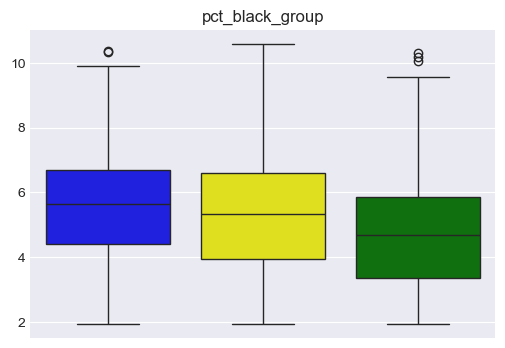

In [1255]:
# Apply log transformation to the visits_by_cbg column
combined_data_black['log_visits_by_cbg'] = np.log(combined_data_black['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
black_palette = {'pct_low_black': 'blue', 'pct_moderate_black': 'yellow', 'pct_high_black': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='black_group', y='log_visits_by_cbg', data=combined_data_black, palette=black_palette,hue='black_group')
plt.title('pct_black_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_black_group.png',dpi=300)

## 3)Asian 

In [1256]:
merged_asian = merged_df[['FIPS','pct_asian','visits_by_cbg']]

In [1257]:
merged_asian_ranked = merged_asian.sort_values('pct_asian')

In [1258]:
pct_low_asian = merged_asian_ranked.head(1267)

In [1259]:
pct_moderate_asian = merged_asian_ranked.iloc[1267:2535]

In [1260]:
pct_high_asian = merged_asian_ranked.iloc[2536:3804]

In [1261]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_asian = pct_low_asian['visits_by_cbg'].mean()
pct_mean_visits_moderate_asian = pct_moderate_asian['visits_by_cbg'].mean()
pct_mean_visits_high_asian = pct_high_asian['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_asian: {pct_mean_visits_low_asian}')
print(f'Mean visits for pct_moderate_asian: {pct_mean_visits_moderate_asian}')
print(f'Mean visits for pct_high_asian: {pct_mean_visits_high_asian}')

Mean visits for pct_low_asian: 455.6740331491713
Mean visits for pct_moderate_asian: 765.9014195583596
Mean visits for pct_high_asian: 859.1656151419559


In [1262]:
# perform One_way ANOVA

anova_result_asian = f_oneway(pct_low_asian['visits_by_cbg'], pct_moderate_asian['visits_by_cbg'],pct_high_asian['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_asian.statistic}")
print(f"ANOVA p-value: {anova_result_asian.pvalue}")

ANOVA F-value: 15.198453795643145
ANOVA p-value: 2.664742022940171e-07


In [1263]:
# Step 1: Combine data into a single DataFrame
combined_data_asian = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_asian['visits_by_cbg'], 
        pct_moderate_asian['visits_by_cbg'], 
        pct_high_asian['visits_by_cbg']
    ], ignore_index=True),
    'asian_group': ['pct_low_asian'] * len(pct_low_asian) + 
                    ['pct_moderate_asian'] * len(pct_moderate_asian) + 
                    ['pct_high_asian'] * len(pct_high_asian)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_asian['visits_by_cbg'],
                                  groups=combined_data_asian['asian_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
    group1           group2        meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------
pct_high_asian      pct_low_asian -403.4916    0.0 -583.1509 -223.8322   True
pct_high_asian pct_moderate_asian  -93.2642 0.4429 -272.8881   86.3597  False
 pct_low_asian pct_moderate_asian  310.2274 0.0002   130.568  489.8867   True
-----------------------------------------------------------------------------


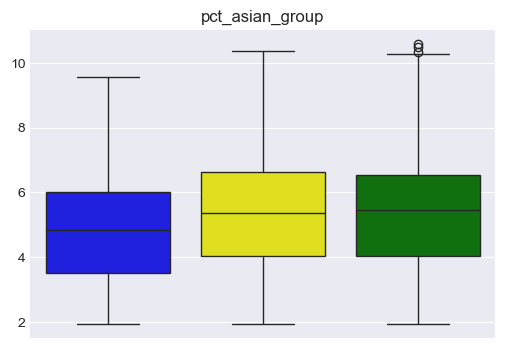

In [1264]:
# Apply log transformation to the visits_by_cbg column
combined_data_asian['log_visits_by_cbg'] = np.log(combined_data_asian['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
asian_palette = {'pct_low_asian': 'blue', 'pct_moderate_asian': 'yellow', 'pct_high_asian': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='asian_group', y='log_visits_by_cbg', data=combined_data_asian, palette=asian_palette,hue='asian_group')
plt.title('pct_asian_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_asian_group.png',dpi=300)

## 4) Unemployment

In [1265]:
merged_unemp = merged_df[['FIPS','pct_unemp','visits_by_cbg']]

In [1266]:
merged_unemp_ranked = merged_unemp.sort_values('pct_unemp')

In [1267]:
pct_low_unemp = merged_unemp_ranked.head(1267)

In [1268]:
pct_moderate_unemp = merged_unemp_ranked.iloc[1267:2535]

In [1269]:
pct_high_unemp= merged_unemp_ranked.iloc[2536:3804]

In [1270]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_uenmp = pct_low_unemp['visits_by_cbg'].mean()
pct_mean_visits_moderate_unemp = pct_moderate_unemp['visits_by_cbg'].mean()
pct_mean_visits_high_unemp = pct_high_unemp['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_unemployment: {pct_mean_visits_low_uenmp}')
print(f'Mean visits for pct_moderate_unemployment: {pct_mean_visits_moderate_unemp}')
print(f'Mean visits for pct_high_unemployment: {pct_mean_visits_high_unemp}')

Mean visits for pct_low_unemployment: 776.2730860299921
Mean visits for pct_moderate_unemployment: 720.6427444794953
Mean visits for pct_high_unemployment: 584.0173501577287


In [1271]:
# perform One_way ANOVA

anova_result_unemp = f_oneway(pct_low_unemp['visits_by_cbg'], pct_moderate_unemp['visits_by_cbg'],pct_high_unemp['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_unemp.statistic}")
print(f"ANOVA p-value: {anova_result_unemp.pvalue}")

ANOVA F-value: 3.3134632532807897
ANOVA p-value: 0.03649509586666401


In [1272]:
# Step 1: Combine data into a single DataFrame
combined_data_unemp = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_unemp['visits_by_cbg'], 
        pct_moderate_unemp['visits_by_cbg'], 
        pct_high_unemp['visits_by_cbg']
    ], ignore_index=True),
    'unemp_group': ['pct_low_unemp'] * len(pct_low_unemp) + 
                    ['pct_moderate_unemp'] * len(pct_moderate_unemp) + 
                    ['pct_high_unemp'] * len(pct_high_unemp)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_unemp['visits_by_cbg'],
                                  groups=combined_data_unemp['unemp_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1           group2       meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------
pct_high_unemp      pct_low_unemp 192.2557 0.0332   12.0358 372.4757   True
pct_high_unemp pct_moderate_unemp 136.6254 0.1772   -43.559 316.8098  False
 pct_low_unemp pct_moderate_unemp -55.6303 0.7494 -235.8503 124.5896  False
---------------------------------------------------------------------------


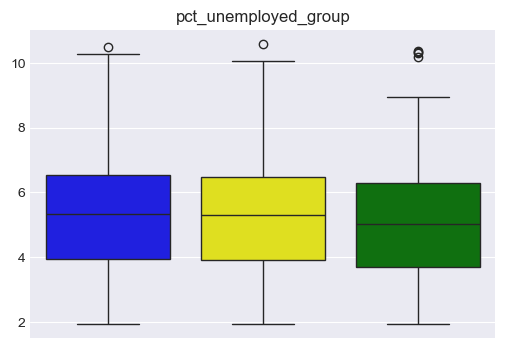

In [1273]:
# Apply log transformation to the visits_by_cbg column
combined_data_unemp['log_visits_by_cbg'] = np.log(combined_data_unemp['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
unemp_palette = {'pct_low_unemp': 'blue', 'pct_moderate_unemp': 'yellow', 'pct_high_unemp': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='unemp_group', y='log_visits_by_cbg', data=combined_data_unemp, palette=unemp_palette,hue='unemp_group')
plt.title('pct_unemployed_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_unemployed_group.png',dpi=300)

## 5) Gender: Female

In [1274]:
merged_female = merged_df[['FIPS','pct_female','visits_by_cbg']]

In [1275]:
merged_female_ranked = merged_female.sort_values('pct_female')

In [1276]:
pct_low_female = merged_female_ranked.head(1267)

In [1277]:
pct_moderate_female = merged_female_ranked.iloc[1267:2535]

In [1278]:
pct_high_female = merged_female_ranked.iloc[2536:3804]

In [1279]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and female percentages
pct_mean_visits_low_female = pct_low_female['visits_by_cbg'].mean()
pct_mean_visits_moderate_female = pct_moderate_female['visits_by_cbg'].mean()
pct_mean_visits_high_female = pct_high_female['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_female: {pct_mean_visits_low_female}')
print(f'Mean visits for pct_moderate_female: {pct_mean_visits_moderate_female}')
print(f'Mean visits for pct_high_female: {pct_mean_visits_high_female}')

Mean visits for pct_low_female: 737.4135753749014
Mean visits for pct_moderate_female: 627.211356466877
Mean visits for pct_high_female: 715.5173501577287


In [1280]:
# perform One_way ANOVA

anova_result_female = f_oneway(pct_low_female['visits_by_cbg'], pct_moderate_female['visits_by_cbg'],pct_high_female['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_female.statistic}")
print(f"ANOVA p-value: {anova_result_female.pvalue}")

ANOVA F-value: 1.151045224827807
ANOVA p-value: 0.3164162433638831


In [1281]:
# Step 1: Combine data into a single DataFrame
combined_data_female = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_female['visits_by_cbg'], 
        pct_moderate_female['visits_by_cbg'], 
        pct_high_female['visits_by_cbg']
    ], ignore_index=True),
    'female_group': ['pct_low_female'] * len(pct_low_female) + 
                    ['pct_moderate_female'] * len(pct_moderate_female) + 
                    ['pct_high_female'] * len(pct_high_female)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_female['visits_by_cbg'],
                                  groups=combined_data_female['female_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1            group2        meandiff p-adj    lower    upper   reject
------------------------------------------------------------------------------
pct_high_female      pct_low_female   21.8962 0.9563 -158.4267 202.2192  False
pct_high_female pct_moderate_female   -88.306 0.4843 -268.5934  91.9814  False
 pct_low_female pct_moderate_female -110.2022 0.3241 -290.5252  70.1208  False
------------------------------------------------------------------------------


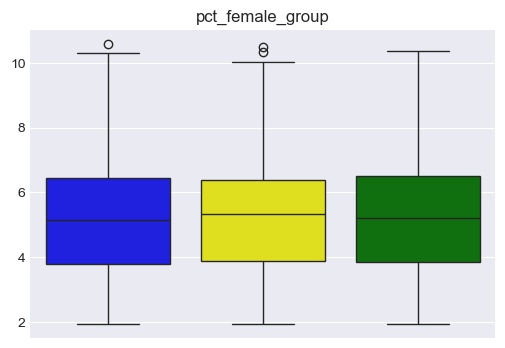

In [1282]:
# Apply log transformation to the visits_by_cbg column
combined_data_female['log_visits_by_cbg'] = np.log(combined_data_female['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
female_palette = {'pct_low_female': 'blue', 'pct_moderate_female': 'yellow', 'pct_high_female': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='female_group', y='log_visits_by_cbg', data=combined_data_female, palette=female_palette,hue='female_group')
plt.title('pct_female_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_female_group.png',dpi=300)

## 6) Age: young

In [1283]:
merged_young = merged_df[['FIPS','pct_young','visits_by_cbg']]

In [1284]:
merged_young_ranked = merged_young.sort_values('pct_young')

In [1285]:
pct_low_young = merged_young_ranked.head(1267)

In [1286]:
pct_moderate_young = merged_young_ranked.iloc[1267:2535]

In [1287]:
pct_high_young = merged_young_ranked.iloc[2536:3804]

In [1288]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and female percentages
pct_mean_visits_low_young = pct_low_young['visits_by_cbg'].mean()
pct_mean_visits_moderate_young = pct_moderate_young['visits_by_cbg'].mean()
pct_mean_visits_high_young = pct_high_young['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_young: {pct_mean_visits_low_young}')
print(f'Mean visits for pct_moderate_young: {pct_mean_visits_moderate_young}')
print(f'Mean visits for pct_high_young: {pct_mean_visits_high_young}')

Mean visits for pct_low_young: 759.8650355169692
Mean visits for pct_moderate_young: 526.7168769716088
Mean visits for pct_high_young: 794.4574132492114


In [1289]:
# perform One_way ANOVA

anova_result_young = f_oneway(pct_low_young['visits_by_cbg'], pct_moderate_young['visits_by_cbg'],pct_high_young['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_young.statistic}")
print(f"ANOVA p-value: {anova_result_young.pvalue}")

ANOVA F-value: 7.195606712794435
ANOVA p-value: 0.0007601342051883872


In [1290]:
# Step 1: Combine data into a single DataFrame
combined_data_young = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_young['visits_by_cbg'], 
        pct_moderate_young['visits_by_cbg'], 
        pct_high_young['visits_by_cbg']
    ], ignore_index=True),
    'young_group': ['pct_low_young'] * len(pct_low_young) + 
                    ['pct_moderate_young'] * len(pct_moderate_young) + 
                    ['pct_high_young'] * len(pct_high_young)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_young['visits_by_cbg'],
                                  groups=combined_data_young['young_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
    group1           group2        meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------------
pct_high_young      pct_low_young  -34.5924 0.8942 -214.6277 145.4429  False
pct_high_young pct_moderate_young -267.7405 0.0014 -447.7403 -87.7408   True
 pct_low_young pct_moderate_young -233.1482 0.0068 -413.1834 -53.1129   True
----------------------------------------------------------------------------


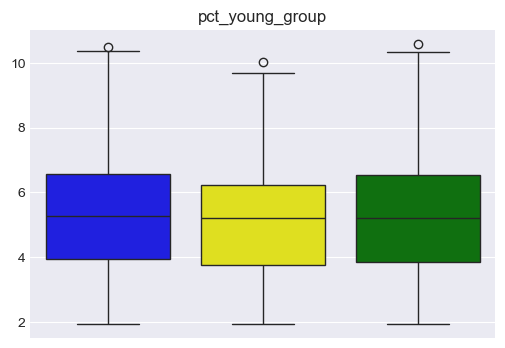

In [1291]:
# Apply log transformation to the visits_by_cbg column
combined_data_young['log_visits_by_cbg'] = np.log(combined_data_young['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
young_palette = {'pct_low_young': 'blue', 'pct_moderate_young': 'yellow', 'pct_high_young': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='young_group', y='log_visits_by_cbg', data=combined_data_young, palette=young_palette,hue='young_group')
plt.title('pct_young_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_young_group.png',dpi=300)

# 7) Age: Adult

In [1292]:
merged_adult = merged_df[['FIPS','pct_adult','visits_by_cbg']]

In [1293]:
merged_adult_ranked = merged_adult.sort_values('pct_adult')

In [1294]:
pct_low_adult = merged_adult_ranked.head(1267)

In [1295]:
pct_moderate_adult = merged_adult_ranked.iloc[1267:2535]

In [1296]:
pct_high_adult = merged_adult_ranked.iloc[2536:3804]

In [1297]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and female percentages
pct_mean_visits_low_adult = pct_low_adult['visits_by_cbg'].mean()
pct_mean_visits_moderate_adult = pct_moderate_adult['visits_by_cbg'].mean()
pct_mean_visits_high_adult = pct_high_adult['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_adult: {pct_mean_visits_low_adult}')
print(f'Mean visits for pct_moderate_adult: {pct_mean_visits_moderate_adult}')
print(f'Mean visits for pct_high_adult: {pct_mean_visits_high_adult}')

Mean visits for pct_low_adult: 755.0055248618785
Mean visits for pct_moderate_adult: 709.051261829653
Mean visits for pct_high_adult: 616.9826498422713


In [1298]:
# perform One_way ANOVA

anova_result_adult = f_oneway(pct_low_adult['visits_by_cbg'], pct_moderate_adult['visits_by_cbg'],pct_high_adult['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_adult.statistic}")
print(f"ANOVA p-value: {anova_result_adult.pvalue}")

ANOVA F-value: 1.6708974456245034
ANOVA p-value: 0.18821635262082603


In [1299]:
# Step 1: Combine data into a single DataFrame
combined_data_adult = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_adult['visits_by_cbg'], 
        pct_moderate_adult['visits_by_cbg'], 
        pct_high_adult['visits_by_cbg']
    ], ignore_index=True),
    'adult_group': ['pct_low_adult'] * len(pct_low_adult) + 
                    ['pct_moderate_adult'] * len(pct_moderate_adult) + 
                    ['pct_high_adult'] * len(pct_high_adult)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_adult['visits_by_cbg'],
                                  groups=combined_data_adult['adult_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1           group2       meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------
pct_high_adult      pct_low_adult 138.0229 0.1714  -42.2737 318.3194  False
pct_high_adult pct_moderate_adult  92.0686 0.4547  -88.1924 272.3296  False
 pct_low_adult pct_moderate_adult -45.9543 0.8214 -226.2508 134.3423  False
---------------------------------------------------------------------------


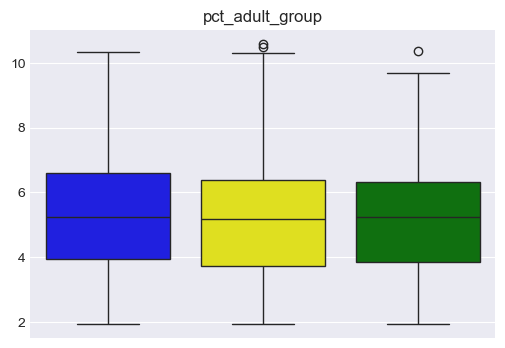

In [1300]:
# Apply log transformation to the visits_by_cbg column
combined_data_adult['log_visits_by_cbg'] = np.log(combined_data_adult['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
adult_palette = {'pct_low_adult': 'blue', 'pct_moderate_adult': 'yellow', 'pct_high_adult': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='adult_group', y='log_visits_by_cbg', data=combined_data_adult, palette=adult_palette,hue='adult_group')
plt.title('pct_adult_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_adult_group.png',dpi=300)

## 8) Age: Elderly

In [1301]:
merged_elderly = merged_df[['FIPS','pct_elderly','visits_by_cbg']]

In [1302]:
merged_elderly_ranked = merged_elderly.sort_values('pct_elderly')

In [1303]:
pct_low_elderly = merged_elderly_ranked.head(1267)

In [1304]:
pct_moderate_elderly = merged_elderly_ranked.iloc[1267:2535]

In [1305]:
pct_high_elderly = merged_elderly_ranked.iloc[2535:3804]

In [1306]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and female percentages
pct_mean_visits_low_elderly = pct_low_elderly['visits_by_cbg'].mean()
pct_mean_visits_moderate_elderly = pct_moderate_elderly['visits_by_cbg'].mean()
pct_mean_visits_high_elderly = pct_high_elderly['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_elderly: {pct_mean_visits_low_elderly}')
print(f'Mean visits for pct_moderate_elderly: {pct_mean_visits_moderate_elderly}')
print(f'Mean visits for pct_high_elderly: {pct_mean_visits_high_elderly}')

Mean visits for pct_low_elderly: 809.1333859510655
Mean visits for pct_moderate_elderly: 539.3927444794953
Mean visits for pct_high_elderly: 731.9866036249015


In [1307]:
# perform One_way ANOVA

anova_result_elderly = f_oneway(pct_low_elderly['visits_by_cbg'], pct_moderate_elderly['visits_by_cbg'],pct_high_elderly['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_elderly.statistic}")
print(f"ANOVA p-value: {anova_result_elderly.pvalue}")

ANOVA F-value: 6.547123379596446
ANOVA p-value: 0.0014504637250999193


In [1308]:
# Step 1: Combine data into a single DataFrame
combined_data_elderly = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_elderly['visits_by_cbg'], 
        pct_moderate_elderly['visits_by_cbg'], 
        pct_high_elderly['visits_by_cbg']
    ], ignore_index=True),
    'elderly_group': ['pct_low_elderly'] * len(pct_low_elderly) + 
                    ['pct_moderate_elderly'] * len(pct_moderate_elderly) + 
                    ['pct_high_elderly'] * len(pct_high_elderly)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_elderly['visits_by_cbg'],
                                  groups=combined_data_elderly['elderly_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1             group2         meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------------
pct_high_elderly      pct_low_elderly   77.1468 0.5738 -102.8629 257.1565  False
pct_high_elderly pct_moderate_elderly -192.5939 0.0325 -372.5681 -12.6197   True
 pct_low_elderly pct_moderate_elderly -269.7406 0.0013 -449.7858 -89.6955   True
--------------------------------------------------------------------------------


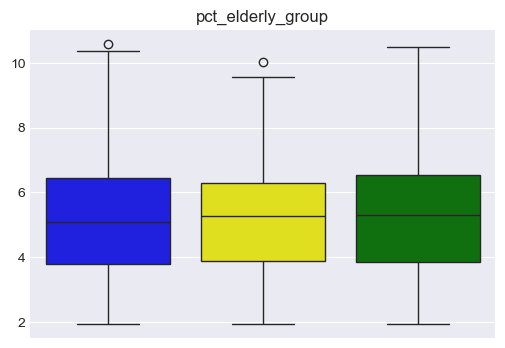

In [1309]:
# Apply log transformation to the visits_by_cbg column
combined_data_elderly['log_visits_by_cbg'] = np.log(combined_data_elderly['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
elderly_palette = {'pct_low_elderly': 'blue', 'pct_moderate_elderly': 'yellow', 'pct_high_elderly': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='elderly_group', y='log_visits_by_cbg', data=combined_data_elderly, palette=elderly_palette,hue='elderly_group')
plt.title('pct_elderly_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_elderly_group.png',dpi=300)

## 9) Education: Less high High

In [1310]:
merged_lessHigh = merged_df[['FIPS','pct_low_edu','visits_by_cbg']]

In [1311]:
merged_lessHigh_ranked = merged_lessHigh.sort_values('pct_low_edu')

In [1312]:
pct_low_lessHigh = merged_lessHigh_ranked.head(1267)

In [1313]:
pct_moderate_lessHigh = merged_lessHigh_ranked.iloc[1267:2535]

In [1314]:
pct_high_lessHigh = merged_lessHigh_ranked.iloc[2536:3804]

In [1315]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_lessHigh = pct_low_lessHigh['visits_by_cbg'].mean()
pct_mean_visits_moderate_lessHigh = pct_moderate_lessHigh['visits_by_cbg'].mean()
pct_mean_visits_high_lessHigh = pct_high_lessHigh['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_LessHighsch: {pct_mean_visits_low_lessHigh}')
print(f'Mean visits for pct_moderate_LessHighSch: {pct_mean_visits_moderate_lessHigh}')
print(f'Mean visits for pct_high_LessHighSch: {pct_mean_visits_high_lessHigh}')

Mean visits for pct_low_LessHighsch: 1078.0457774269928
Mean visits for pct_moderate_LessHighSch: 551.0599369085173
Mean visits for pct_high_LessHighSch: 452.1656151419558


In [1316]:
# perform One_way ANOVA

anova_result_lessHigh = f_oneway(pct_low_lessHigh['visits_by_cbg'], pct_moderate_lessHigh['visits_by_cbg'],pct_high_lessHigh['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_lessHigh.statistic}")
print(f"ANOVA p-value: {anova_result_lessHigh.pvalue}")

ANOVA F-value: 39.03522782709113
ANOVA p-value: 1.6558201640179548e-17


In [1317]:
# Step 1: Combine data into a single DataFrame
combined_data_lessHigh = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_lessHigh['visits_by_cbg'], 
        pct_moderate_lessHigh['visits_by_cbg'], 
        pct_high_lessHigh['visits_by_cbg']
    ], ignore_index=True),
    'lessHigh_group': ['pct_low_lessHigh'] * len(pct_low_lessHigh) + 
                    ['pct_moderate_lessHigh'] * len(pct_moderate_lessHigh) + 
                    ['pct_high_lessHigh'] * len(pct_high_lessHigh)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_lessHigh['visits_by_cbg'],
                                  groups=combined_data_lessHigh['lessHigh_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
      group1              group2         meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------------
pct_high_lessHigh      pct_low_lessHigh  625.8802    0.0  447.3289  804.4314   True
pct_high_lessHigh pct_moderate_lessHigh   98.8943 0.3959  -79.6217  277.4103  False
 pct_low_lessHigh pct_moderate_lessHigh -526.9858    0.0 -705.5371 -348.4346   True
-----------------------------------------------------------------------------------


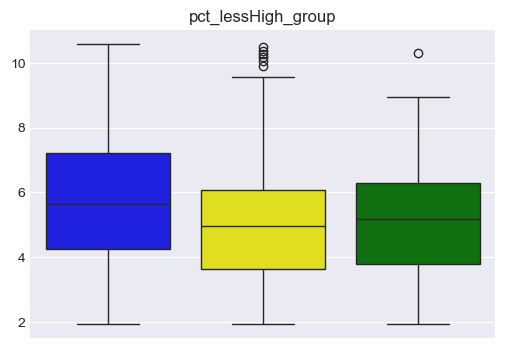

In [1318]:
# Apply log transformation to the visits_by_cbg column
combined_data_lessHigh['log_visits_by_cbg'] = np.log(combined_data_lessHigh['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
lessHigh_palette = {'pct_low_lessHigh': 'blue', 'pct_moderate_lessHigh': 'yellow', 'pct_high_lessHigh': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='lessHigh_group', y='log_visits_by_cbg', data=combined_data_lessHigh, palette=lessHigh_palette,hue='lessHigh_group')
plt.title('pct_lessHigh_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_lessHigh_group.png',dpi=300)

## 10) Education: high school

In [1319]:
merged_highsch = merged_df[['FIPS','pct_high_edu','visits_by_cbg']]

In [1320]:
merged_highsch_ranked = merged_highsch.sort_values('pct_high_edu')

In [1321]:
pct_low_highsch = merged_highsch_ranked.head(1267)

In [1322]:
pct_moderate_highsch = merged_highsch_ranked.iloc[1267:2535]

In [1323]:
pct_high_highsch = merged_highsch_ranked.iloc[2536:3804]

In [1324]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_High = pct_low_highsch['visits_by_cbg'].mean()
pct_mean_visits_moderate_High = pct_moderate_highsch['visits_by_cbg'].mean()
pct_mean_visits_high_High = pct_high_highsch['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_Highsch: {pct_mean_visits_low_High}')
print(f'Mean visits for pct_moderate_HighSch: {pct_mean_visits_moderate_High}')
print(f'Mean visits for pct_high_HighSch: {pct_mean_visits_high_High}')

Mean visits for pct_low_Highsch: 452.0181531176006
Mean visits for pct_moderate_HighSch: 551.3414826498423
Mean visits for pct_high_HighSch: 1077.2121451104101


In [1325]:
# perform One_way ANOVA

anova_result_highsch = f_oneway(pct_low_highsch['visits_by_cbg'], pct_moderate_highsch['visits_by_cbg'],pct_high_highsch['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_highsch.statistic}")
print(f"ANOVA p-value: {anova_result_highsch.pvalue}")

ANOVA F-value: 38.932594786917406
ANOVA p-value: 1.831006878762494e-17


In [1326]:
# Step 1: Combine data into a single DataFrame
combined_data_highsch = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_highsch['visits_by_cbg'], 
        pct_moderate_highsch['visits_by_cbg'], 
        pct_high_highsch['visits_by_cbg']
    ], ignore_index=True),
    'highsch_group': ['pct_low_highsch'] * len(pct_low_highsch) + 
                    ['pct_moderate_highsch'] * len(pct_moderate_highsch) + 
                    ['pct_high_highsch'] * len(pct_high_highsch)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_highsch['visits_by_cbg'],
                                  groups=combined_data_highsch['highsch_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1             group2         meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------------------
pct_high_highsch      pct_low_highsch  -625.194    0.0 -803.7517 -446.6363   True
pct_high_highsch pct_moderate_highsch -525.8707    0.0 -704.3931 -347.3482   True
 pct_low_highsch pct_moderate_highsch   99.3233 0.3929  -79.2344   277.881  False
---------------------------------------------------------------------------------


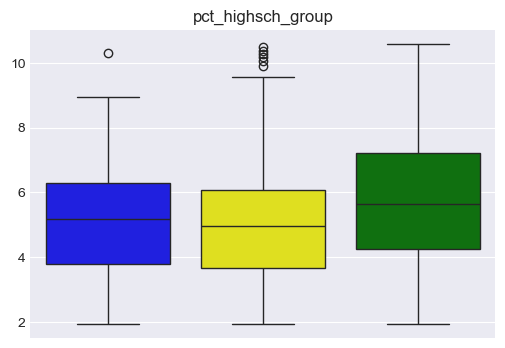

In [1327]:
# Apply log transformation to the visits_by_cbg column
combined_data_highsch['log_visits_by_cbg'] = np.log(combined_data_highsch['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
highsch_palette = {'pct_low_highsch': 'blue', 'pct_moderate_highsch': 'yellow', 'pct_high_highsch': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='highsch_group', y='log_visits_by_cbg', data=combined_data_highsch, palette=highsch_palette,hue='highsch_group')
plt.title('pct_highsch_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_highsch_group.png',dpi=300)

## 11) Transportation: car

In [1328]:
merged_car = merged_df[['FIPS','pct_car','visits_by_cbg']]

In [1329]:
merged_car_ranked = merged_car.sort_values('pct_car')

In [1330]:
pct_low_car = merged_car_ranked.head(1267)

In [1331]:
pct_moderate_car = merged_car_ranked.iloc[1267:2535]

In [1332]:
pct_high_car = merged_car_ranked.iloc[2536:3804]

In [1333]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_car = pct_low_car['visits_by_cbg'].mean()
pct_mean_visits_moderate_car = pct_moderate_car['visits_by_cbg'].mean()
pct_mean_visits_high_car = pct_high_car['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_car: {pct_mean_visits_low_car}')
print(f'Mean visits for pct_moderate_car: {pct_mean_visits_moderate_car}')
print(f'Mean visits for pct_high_car: {pct_mean_visits_high_car}')

Mean visits for pct_low_car: 1304.6732438831887
Mean visits for pct_moderate_car: 486.09069400630915
Mean visits for pct_high_car: 290.59069400630915


In [1334]:
# perform One_way ANOVA

anova_result_car = f_oneway(pct_low_car['visits_by_cbg'], pct_moderate_car['visits_by_cbg'],pct_high_car['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_car.statistic}")
print(f"ANOVA p-value: {anova_result_car.pvalue}")

ANOVA F-value: 103.10443574681057
ANOVA p-value: 2.4832230699913883e-44


In [1335]:
# Step 1: Combine data into a single DataFrame
combined_data_car = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_car['visits_by_cbg'], 
        pct_moderate_car['visits_by_cbg'], 
        pct_high_car['visits_by_cbg']
    ], ignore_index=True),
    'car_group': ['pct_low_car'] * len(pct_low_car) + 
                    ['pct_moderate_car'] * len(pct_moderate_car) + 
                    ['pct_high_car'] * len(pct_high_car)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_car['visits_by_cbg'],
                                  groups=combined_data_car['car_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
   group1         group2       meandiff p-adj   lower     upper   reject
------------------------------------------------------------------------
pct_high_car      pct_low_car 1014.0825    0.0 838.4091  1189.756   True
pct_high_car pct_moderate_car     195.5 0.0247  19.8612  371.1388   True
 pct_low_car pct_moderate_car -818.5825    0.0 -994.256 -642.9091   True
------------------------------------------------------------------------


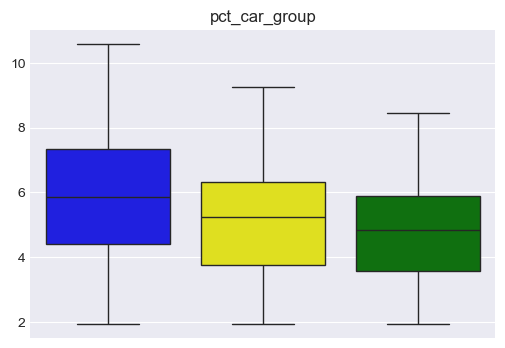

In [1336]:
# Apply log transformation to the visits_by_cbg column
combined_data_car['log_visits_by_cbg'] = np.log(combined_data_car['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
car_palette = {'pct_low_car': 'blue', 'pct_moderate_car': 'yellow', 'pct_high_car': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='car_group', y='log_visits_by_cbg', data=combined_data_car, palette=car_palette,hue='car_group')
plt.title('pct_car_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_car_group.png',dpi=300)

## 12) Transport: 0car

In [1337]:
merged_0car = merged_df[['FIPS','pct_0car','visits_by_cbg']]

In [1338]:
merged_0car_ranked = merged_0car.sort_values('pct_0car')

In [1339]:
pct_low_0car = merged_0car_ranked.head(1267)

In [1340]:
pct_moderate_0car = merged_0car_ranked.iloc[1267:2535]

In [1341]:
pct_high_0car = merged_0car_ranked.iloc[1267:2535]

In [1342]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_0car = pct_low_0car['visits_by_cbg'].mean()
pct_mean_visits_moderate_0car = pct_moderate_0car['visits_by_cbg'].mean()
pct_mean_visits_high_0car = pct_high_0car['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_0car: {pct_mean_visits_low_0car}')
print(f'Mean visits for pct_moderate_0car: {pct_mean_visits_moderate_0car}')
print(f'Mean visits for pct_high_0car: {pct_mean_visits_high_0car}')

Mean visits for pct_low_0car: 356.09707971586425
Mean visits for pct_moderate_0car: 451.29652996845425
Mean visits for pct_high_0car: 451.29652996845425


In [1343]:
# perform One_way ANOVA

anova_result_0car = f_oneway(pct_low_0car['visits_by_cbg'], pct_moderate_0car['visits_by_cbg'],pct_high_0car['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_0car.statistic}")
print(f"ANOVA p-value: {anova_result_0car.pvalue}")

ANOVA F-value: 7.9194436758931435
ANOVA p-value: 0.00036963860724644176


In [1344]:
# Step 1: Combine data into a single DataFrame
combined_data_0car = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_0car['visits_by_cbg'], 
        pct_moderate_0car['visits_by_cbg'], 
        pct_high_0car['visits_by_cbg']
    ], ignore_index=True),
    '0car_group': ['pct_low_0car'] * len(pct_low_0car) + 
                    ['pct_moderate_0car'] * len(pct_moderate_0car) + 
                    ['pct_high_0car'] * len(pct_high_0car)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_0car['visits_by_cbg'],
                                  groups=combined_data_0car['0car_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1          group2      meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------------
pct_high_0car      pct_low_0car -95.1995 0.0017 -159.9563 -30.4426   True
pct_high_0car pct_moderate_0car      0.0    1.0  -64.7441  64.7441  False
 pct_low_0car pct_moderate_0car  95.1995 0.0017   30.4426 159.9563   True
-------------------------------------------------------------------------


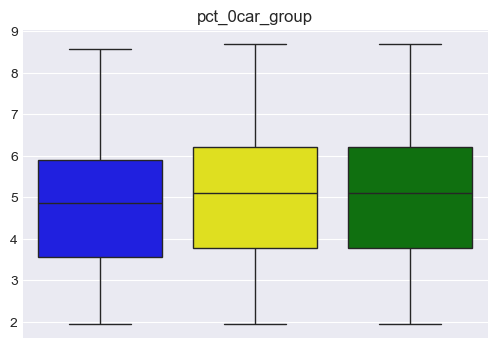

In [1345]:
# Apply log transformation to the visits_by_cbg column
combined_data_0car['log_visits_by_cbg'] = np.log(combined_data_0car['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Zcar_palette = {'pct_low_0car': 'blue', 'pct_moderate_0car': 'yellow', 'pct_high_0car': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='0car_group', y='log_visits_by_cbg', data=combined_data_0car, palette=Zcar_palette,hue='0car_group')
plt.title('pct_0car_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_0car_group.png',dpi=300)

## 13) Transport: public trans

In [1346]:
merged_public_trans = merged_df[['FIPS','pct_public_trans','visits_by_cbg']]

In [1347]:
merged_public_trans_ranked = merged_public_trans.sort_values('pct_public_trans')

In [1348]:
pct_low_public_trans = merged_public_trans_ranked.head(1267)

In [1349]:
pct_moderate_public_trans = merged_public_trans_ranked.iloc[1267:2535]

In [1350]:
pct_high_public_trans = merged_public_trans_ranked.iloc[2536:3804]

In [1351]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_public_trans = pct_low_public_trans['visits_by_cbg'].mean()
pct_mean_visits_moderate_public_trans = pct_moderate_public_trans['visits_by_cbg'].mean()
pct_mean_visits_high_public_trans = pct_high_public_trans['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_public_trans: {pct_mean_visits_low_public_trans}')
print(f'Mean visits for pct_moderate_public_trans: {pct_mean_visits_moderate_public_trans}')
print(f'Mean visits for pct_high_public_trans: {pct_mean_visits_high_public_trans}')

Mean visits for pct_low_public_trans: 559.1254932912392
Mean visits for pct_moderate_public_trans: 863.1206624605678
Mean visits for pct_high_public_trans: 657.4810725552051


In [1352]:
# perform One_way ANOVA

anova_result_public_trans = f_oneway(pct_low_public_trans['visits_by_cbg'], pct_moderate_public_trans['visits_by_cbg'],pct_high_public_trans['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_public_trans.statistic}")
print(f"ANOVA p-value: {anova_result_public_trans.pvalue}")

ANOVA F-value: 8.167113484956253
ANOVA p-value: 0.0002888478340620279


In [1353]:
# Step 1: Combine data into a single DataFrame
combined_data_public_trans = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_public_trans['visits_by_cbg'], 
        pct_moderate_public_trans['visits_by_cbg'], 
        pct_high_public_trans['visits_by_cbg']
    ], ignore_index=True),
    'public_trans_group': ['pct_low_public_trans'] * len(pct_low_public_trans) + 
                    ['pct_moderate_public_trans'] * len(pct_moderate_public_trans) + 
                    ['pct_high_public_trans'] * len(pct_high_public_trans)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_public_trans['visits_by_cbg'],
                                  groups=combined_data_public_trans['public_trans_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
        group1                  group2          meandiff p-adj   lower    upper   reject
----------------------------------------------------------------------------------------
pct_high_public_trans      pct_low_public_trans -98.3556 0.4059 -278.344  81.6329  False
pct_high_public_trans pct_moderate_public_trans 205.6396 0.0203  25.6866 385.5926   True
 pct_low_public_trans pct_moderate_public_trans 303.9952 0.0002 124.0067 483.9836   True
----------------------------------------------------------------------------------------


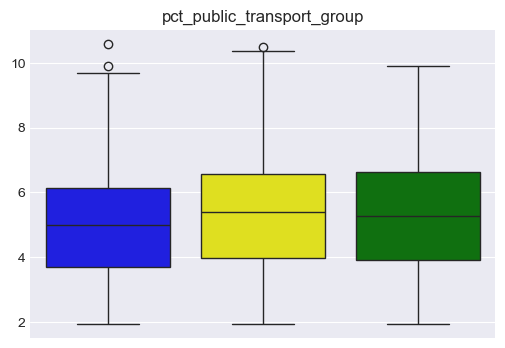

In [1354]:
# Apply log transformation to the visits_by_cbg column
combined_data_public_trans['log_visits_by_cbg'] = np.log(combined_data_public_trans['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
public_trans_palette = {'pct_low_public_trans': 'blue', 'pct_moderate_public_trans': 'yellow', 'pct_high_public_trans': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='public_trans_group', y='log_visits_by_cbg', data=combined_data_public_trans, palette=public_trans_palette,hue='public_trans_group')
plt.title('pct_public_transport_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_public_trans_group.png',dpi=300)

## 14) Commute: Short commute

In [1355]:
merged_short_commute = merged_df[['FIPS','pct_short_comute','visits_by_cbg']]

In [1356]:
merged_short_commute_ranked = merged_short_commute.sort_values('pct_short_comute')

In [1357]:
pct_low_Scomute = merged_short_commute_ranked.head(1267)

In [1358]:
pct_moderate_Scomute = merged_short_commute_ranked.iloc[1267:2535]

In [1359]:
pct_high_Scomute = merged_short_commute_ranked.iloc[2536:3804]

In [1360]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_shortcommute = pct_low_Scomute['visits_by_cbg'].mean()
pct_mean_visits_moderate_shortcommute = pct_moderate_Scomute['visits_by_cbg'].mean()
pct_mean_visits_high_shortcommute = pct_high_Scomute['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_shortcommute: {pct_mean_visits_low_shortcommute}')
print(f'Mean visits for pct_moderate_shortcommute: {pct_mean_visits_moderate_shortcommute}')
print(f'Mean visits for pct_high_shortcommute: {pct_mean_visits_high_shortcommute}')

Mean visits for pct_low_shortcommute: 341.5485398579321
Mean visits for pct_moderate_shortcommute: 401.15141955835963
Mean visits for pct_high_shortcommute: 1336.6971608832807


In [1361]:
# perform One_way ANOVA

anova_result_Scomute = f_oneway(pct_low_Scomute['visits_by_cbg'], pct_moderate_Scomute['visits_by_cbg'],pct_high_Scomute['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_Scomute.statistic}")
print(f"ANOVA p-value: {anova_result_Scomute.pvalue}")

ANOVA F-value: 111.47681846416903
ANOVA p-value: 8.980102501327408e-48


In [1362]:
# Step 1: Combine data into a single DataFrame
combined_data_Scomute = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_Scomute['visits_by_cbg'], 
        pct_moderate_Scomute['visits_by_cbg'], 
        pct_high_Scomute['visits_by_cbg']
    ], ignore_index=True),
    'Scomute_group': ['pct_low_Scomute'] * len(pct_low_Scomute) + 
                    ['pct_moderate_Scomute'] * len(pct_moderate_Scomute) + 
                    ['pct_high_Scomute'] * len(pct_high_Scomute)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_Scomute['visits_by_cbg'],
                                  groups=combined_data_Scomute['Scomute_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
     group1             group2         meandiff p-adj    lower      upper   reject
----------------------------------------------------------------------------------
pct_high_Scomute      pct_low_Scomute -995.1486    0.0 -1170.4519 -819.8454   True
pct_high_Scomute pct_moderate_Scomute -935.5457    0.0 -1110.8144 -760.2771   True
 pct_low_Scomute pct_moderate_Scomute   59.6029 0.7048  -115.7004  234.9061  False
----------------------------------------------------------------------------------


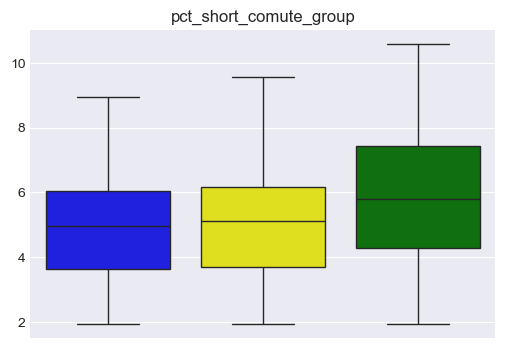

In [1363]:
# Apply log transformation to the visits_by_cbg column
combined_data_Scomute['log_visits_by_cbg'] = np.log(combined_data_Scomute['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Scomute_palette = {'pct_low_Scomute': 'blue', 'pct_moderate_Scomute': 'yellow', 'pct_high_Scomute': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='Scomute_group', y='log_visits_by_cbg', data=combined_data_Scomute, palette=Scomute_palette,hue='Scomute_group')
plt.title('pct_short_comute_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_Scomute_group.png',dpi=300)

## 15) Commute : long comute

In [1364]:
merged_Lcomute = merged_df[['FIPS','pct_long_comute','visits_by_cbg']]

In [1365]:
merged_Lcomute_ranked = merged_Lcomute.sort_values('pct_long_comute')

In [1366]:
pct_low_Lcomute = merged_Lcomute_ranked.head(1267)

In [1367]:
pct_moderate_Lcomute =merged_Lcomute_ranked.iloc[1267:2535]

In [1368]:
pct_high_Lcomute = merged_Lcomute_ranked.iloc[2536:3804]

In [1369]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_longcommute = pct_low_Lcomute['visits_by_cbg'].mean()
pct_mean_visits_moderate_longcommute = pct_moderate_Lcomute['visits_by_cbg'].mean()
pct_mean_visits_high_longcommute = pct_high_Lcomute['visits_by_cbg'].mean()

print(f'Mean visits for pct_low_longcommute: {pct_mean_visits_low_longcommute}')
print(f'Mean visits for pct_moderate_longcommute: {pct_mean_visits_moderate_longcommute}')
print(f'Mean visits for pct_high_longcommute: {pct_mean_visits_high_longcommute}')

Mean visits for pct_low_longcommute: 1337.7063930544593
Mean visits for pct_moderate_longcommute: 401.8706624605678
Mean visits for pct_high_longcommute: 341.5851735015773


In [1370]:
# perform One_way ANOVA

anova_result_Lcomute = f_oneway(pct_low_Lcomute['visits_by_cbg'], pct_moderate_Lcomute['visits_by_cbg'],pct_high_Lcomute['visits_by_cbg'])

# Print the results
print(f"ANOVA F-value: {anova_result_Lcomute.statistic}")
print(f"ANOVA p-value: {anova_result_Lcomute.pvalue}")

ANOVA F-value: 111.58755510521432
ANOVA p-value: 8.088267880802924e-48


In [1371]:
# Step 1: Combine data into a single DataFrame
combined_data_Lcomute = pd.DataFrame({
    'visits_by_cbg': pd.concat([
        pct_low_Lcomute['visits_by_cbg'], 
        pct_moderate_Lcomute['visits_by_cbg'], 
        pct_high_Lcomute['visits_by_cbg']
    ], ignore_index=True),
    'Lcomute_group': ['pct_low_Lcomute'] * len(pct_low_Lcomute) + 
                    ['pct_moderate_Lcomute'] * len(pct_moderate_Lcomute) + 
                    ['pct_high_Lcomute'] * len(pct_high_Lcomute)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_Lcomute['visits_by_cbg'],
                                  groups=combined_data_Lcomute['Lcomute_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1             group2         meandiff p-adj   lower      upper   reject
---------------------------------------------------------------------------------
pct_high_Lcomute      pct_low_Lcomute  996.1212   0.0   820.8172 1171.4252   True
pct_high_Lcomute pct_moderate_Lcomute   60.2855 0.699  -114.9839  235.5549  False
 pct_low_Lcomute pct_moderate_Lcomute -935.8357   0.0 -1111.1397 -760.5317   True
---------------------------------------------------------------------------------


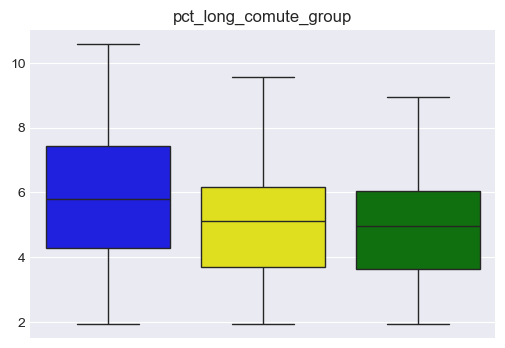

In [1372]:
# Apply log transformation to the visits_by_cbg column
combined_data_Lcomute['log_visits_by_cbg'] = np.log(combined_data_Lcomute['visits_by_cbg'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Lcomute_palette = {'pct_low_Lcomute': 'blue', 'pct_moderate_Lcomute': 'yellow', 'pct_high_Lcomute': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='Lcomute_group', y='log_visits_by_cbg', data=combined_data_Lcomute, palette=Lcomute_palette,hue='Lcomute_group')
plt.title('pct_long_comute_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([]) 
plt.savefig('pct_Lcommute_group.png',dpi=300)

# Does Socioeconomic factors influence how long people spend in parks in NYC?

## 16) Income category

In [1373]:
merged_income_dw = merged_df[['FIPS','median_income','median_dwell']]

In [1374]:
merged_income_ranked = merged_income_dw.sort_values('median_income')

In [1375]:
pct_low_income = merged_income_ranked.head(1267)
pct_median_income = merged_income_ranked.iloc[1267:2535]
pct_high_income = merged_income_ranked.iloc[2536:3804]

In [1376]:
# perform One_way ANOVA

anova_result_income= f_oneway(pct_low_income['median_dwell'], pct_median_income['median_dwell'],pct_high_income['median_dwell'])


In [1377]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_income_dw = pct_low_income['median_dwell'].mean()
pct_mean_visits_moderate_income_dw = pct_median_income['median_dwell'].mean()
pct_mean_visits_high_income_dw = pct_high_income['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_income: {pct_mean_visits_low_income_dw}')
print(f'Mean park dwell time for pct_moderate_income: {pct_mean_visits_moderate_income_dw}')
print(f'Mean park dwell time for pct_high_income: {pct_mean_visits_high_income_dw}')

Mean park dwell time for pct_low_income: 773.3157063930545
Mean park dwell time for pct_moderate_income: 606.5985804416404
Mean park dwell time for pct_high_income: 887.2413249211356


In [1378]:
# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 18.451089475021735
ANOVA p-value: 1.0603569883976293e-08


In [1379]:
# Step 1: Combine data into a single DataFrame
combined_data = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_income['median_dwell'], 
        pct_median_income['median_dwell'], 
        pct_high_income['median_dwell']
    ], ignore_index=True),
    'income_group': ['pct_low_income'] * len(pct_low_income) + 
                    ['pct_median_income'] * len(pct_median_income) + 
                    ['pct_high_income'] * len(pct_high_income)
})
# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data['median_dwell'],
                                  groups=combined_data['income_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

# Apply log transformation to the visits_by_cbg column
combined_data['log_median_dwell'] = np.log(combined_data['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
income_palette = {'pct_low_income': 'blue', 'pct_median_income': 'yellow', 'pct_high_income': 'green'}


            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1           group2       meandiff p-adj   lower     upper   reject
----------------------------------------------------------------------------
pct_high_income    pct_low_income -113.9256 0.038 -222.9017   -4.9496   True
pct_high_income pct_median_income -280.6427   0.0 -389.5973 -171.6882   True
 pct_low_income pct_median_income -166.7171 0.001 -275.6932  -57.7411   True
----------------------------------------------------------------------------


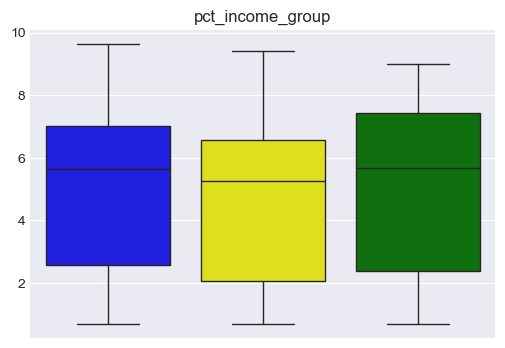

In [1380]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='income_group', y='log_median_dwell', data=combined_data, palette=income_palette,hue='income_group')
plt.title('pct_income_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_income_group_dw.png',dpi=300)


## 17) Black

In [1381]:
merged_race_dw = merged_df[['FIPS','pct_black','median_dwell']]
merged_race_ranked = merged_race_dw.sort_values('pct_black')

In [1382]:
pct_low_black = merged_race_ranked.head(1268)
pct_moderate_black = merged_race_ranked.iloc[1267:2535]
pct_high_black = merged_race_ranked.iloc[2536:3804]

In [1383]:
# perform One_way ANOVA

anova_result_black = f_oneway(pct_low_black['median_dwell'], pct_moderate_black['median_dwell'],pct_high_black['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_black.statistic}")
print(f"ANOVA p-value: {anova_result_black.pvalue}")

ANOVA F-value: 5.341480022253701
ANOVA p-value: 0.0048247914537516605


In [1384]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_black_dw = pct_low_black['median_dwell'].mean()
pct_mean_visits_moderate_black_dw = pct_moderate_black['median_dwell'].mean()
pct_mean_visits_high_black_dw = pct_high_black['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_black: {pct_mean_visits_low_black_dw}')
print(f'Mean park dwell time for pct_moderate_black: {pct_mean_visits_moderate_black_dw}')
print(f'Mean park dwell time for pct_high_black: {pct_mean_visits_high_black_dw}')

Mean park dwell time for pct_low_black: 758.8162460567823
Mean park dwell time for pct_moderate_black: 830.22476340694
Mean park dwell time for pct_high_black: 677.936119873817


In [1385]:
# Step 1: Combine data into a single DataFrame
combined_data_black = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_black['median_dwell'], 
        pct_moderate_black['median_dwell'], 
        pct_high_black['median_dwell']
    ], ignore_index=True),
    'black_group': ['pct_low_black'] * len(pct_low_black) + 
                    ['pct_moderate_black'] * len(pct_moderate_black) + 
                    ['pct_high_black'] * len(pct_high_black)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_black['median_dwell'],
                                  groups=combined_data_black['black_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1           group2       meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------
pct_high_black      pct_low_black  80.8801 0.1924 -28.4335 190.1937  False
pct_high_black pct_moderate_black 152.2886 0.0032  42.9751 261.6022   True
 pct_low_black pct_moderate_black  71.4085 0.2762 -37.9051 180.7221  False
--------------------------------------------------------------------------


In [1386]:
# Apply log transformation to the visits_by_cbg column
combined_data_black['log_median_dwell'] = np.log(combined_data_black['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
black_palette = {'pct_low_black': 'blue', 'pct_moderate_black': 'yellow', 'pct_high_black': 'green'}


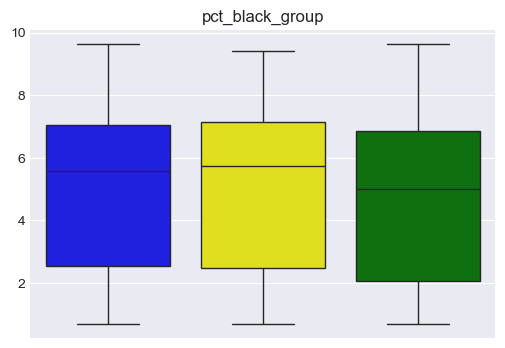

In [1387]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='black_group', y='log_median_dwell', data=combined_data_black, palette=black_palette,hue='black_group')
plt.title('pct_black_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_black_group_dw.png',dpi=300)

## 18) Asian

In [1388]:
merged_asian_dw = merged_df[['FIPS','pct_asian','median_dwell']]
merged_asian_ranked = merged_asian_dw.sort_values('pct_asian')

In [1389]:
pct_low_asian = merged_asian_ranked.head(1267)
pct_moderate_asian = merged_asian_ranked.iloc[1267:2535]
pct_high_asian = merged_asian_ranked.iloc[2536:3804]

In [1390]:
# perform One_way ANOVA

anova_result_asian = f_oneway(pct_low_asian['median_dwell'], pct_moderate_asian['median_dwell'],pct_high_asian['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_asian.statistic}")
print(f"ANOVA p-value: {anova_result_asian.pvalue}")


ANOVA F-value: 5.772151878990125
ANOVA p-value: 0.003140410451263586


In [1391]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_asian_dw = pct_low_asian['median_dwell'].mean()
pct_mean_visits_moderate_asian_dw = pct_moderate_asian['median_dwell'].mean()
pct_mean_visits_high_asian_dw = pct_high_asian['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_asian: {pct_mean_visits_low_asian_dw}')
print(f'Mean park dwell time for pct_moderate_asian: {pct_mean_visits_moderate_asian_dw}')
print(f'Mean park dwell time for pct_high_asian: {pct_mean_visits_high_asian_dw}')

Mean park dwell time for pct_low_asian: 682.8587213891082
Mean park dwell time for pct_moderate_asian: 840.0591482649842
Mean park dwell time for pct_high_asian: 744.3414826498423


In [1392]:
# Step 1: Combine data into a single DataFrame
combined_data_asian = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_asian['median_dwell'], 
        pct_moderate_asian['median_dwell'], 
        pct_high_asian['median_dwell']
    ], ignore_index=True),
    'asian_group': ['pct_low_asian'] * len(pct_low_asian) + 
                    ['pct_moderate_asian'] * len(pct_moderate_asian) + 
                    ['pct_high_asian'] * len(pct_high_asian)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_asian['median_dwell'],
                                  groups=combined_data_asian['asian_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1           group2       meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------
pct_high_asian      pct_low_asian -61.4828 0.3849 -170.8184  47.8529  False
pct_high_asian pct_moderate_asian  95.7177    0.1  -13.5964 205.0317  False
 pct_low_asian pct_moderate_asian 157.2004 0.0022   47.8648 266.5361   True
---------------------------------------------------------------------------


In [1393]:
# Apply log transformation to the visits_by_cbg column
combined_data_asian['log_median_dwell'] = np.log(combined_data_asian['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
asian_palette = {'pct_low_asian': 'blue', 'pct_moderate_asian': 'yellow', 'pct_high_asian': 'green'}


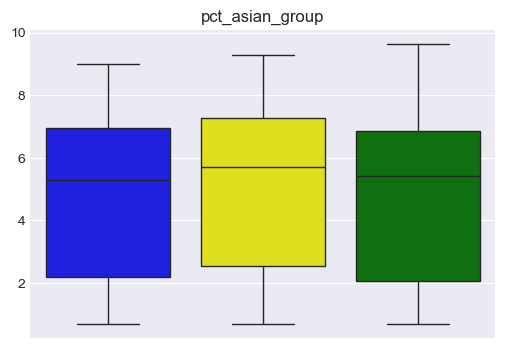

In [1394]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='asian_group', y='log_median_dwell', data=combined_data_asian, palette=asian_palette,hue='asian_group')
plt.title('pct_asian_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_asian_group_dw.png',dpi=300)

## 19) Unemployment

In [1395]:
merged_unemp_dw = merged_df[['FIPS','pct_unemp','median_dwell']]
merged_unemp_ranked = merged_unemp_dw.sort_values('pct_unemp')

In [1396]:
pct_low_unemp = merged_unemp_ranked.head(1267)
pct_moderate_unemp = merged_unemp_ranked.iloc[1267:2535]
pct_high_unemp= merged_unemp_ranked.iloc[2536:3804]

In [1397]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_unemp_dw = pct_low_unemp['median_dwell'].mean()
pct_mean_visits_moderate_unemp_dw = pct_moderate_unemp['median_dwell'].mean()
pct_mean_visits_high_unemp_dw = pct_high_unemp['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_unemp: {pct_mean_visits_low_unemp_dw}')
print(f'Mean park dwell time for pct_moderate_unemp: {pct_mean_visits_moderate_unemp_dw}')
print(f'Mean park dwell time for pct_high_unemp: {pct_mean_visits_high_unemp_dw}')

Mean park dwell time for pct_low_unemp: 791.2138910812944
Mean park dwell time for pct_moderate_unemp: 791.410883280757
Mean park dwell time for pct_high_unemp: 683.4905362776025


In [1398]:
# perform One_way ANOVA

anova_result_unemp = f_oneway(pct_low_unemp['median_dwell'], pct_moderate_unemp['median_dwell'],pct_high_unemp['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_unemp.statistic}")
print(f"ANOVA p-value: {anova_result_unemp.pvalue}")

ANOVA F-value: 3.5612152357088473
ANOVA p-value: 0.028499122977647586


In [1399]:
# Step 1: Combine data into a single DataFrame
combined_data_unemp = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_unemp['median_dwell'], 
        pct_moderate_unemp['median_dwell'], 
        pct_high_unemp['median_dwell']
    ], ignore_index=True),
    'unemp_group': ['pct_low_unemp'] * len(pct_low_unemp) + 
                    ['pct_moderate_unemp'] * len(pct_moderate_unemp) + 
                    ['pct_high_unemp'] * len(pct_high_unemp)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_unemp['median_dwell'],
                                  groups=combined_data_unemp['unemp_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1           group2       meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------
pct_high_unemp      pct_low_unemp 107.7234 0.0547   -1.6704 217.1171  False
pct_high_unemp pct_moderate_unemp 107.9203 0.0541   -1.4518 217.2925  False
 pct_low_unemp pct_moderate_unemp    0.197    1.0 -109.1968 109.5908  False
---------------------------------------------------------------------------


In [1400]:
# Apply log transformation to the visits_by_cbg column
combined_data_unemp['log_median_dwell'] = np.log(combined_data_unemp['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
unemp_palette = {'pct_low_unemp': 'blue', 'pct_moderate_unemp': 'yellow', 'pct_high_unemp': 'green'}

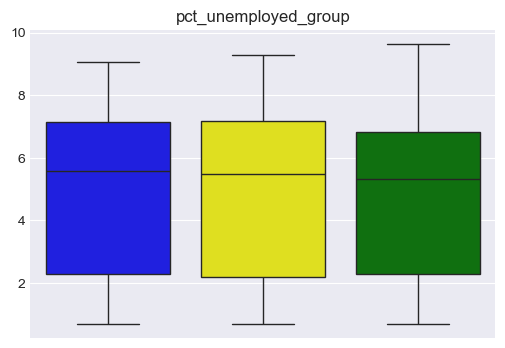

In [1401]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='unemp_group', y='log_median_dwell', data=combined_data_unemp, palette=unemp_palette,hue='unemp_group')
plt.title('pct_unemployed_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_unemployed_group_dw.png',dpi=300)

## 20) Female

In [1402]:
merged_female_dw = merged_df[['FIPS','pct_female','median_dwell']]
merged_female_ranked = merged_female_dw.sort_values('pct_female')

In [1403]:
pct_low_female = merged_female_ranked.head(1267)
pct_moderate_female = merged_female_ranked.iloc[1267:2535]
pct_high_female = merged_female_ranked.iloc[2536:3804]

In [1404]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_female_dw = pct_low_female['median_dwell'].mean()
pct_mean_visits_moderate_female_dw = pct_moderate_female['median_dwell'].mean()
pct_mean_visits_high_female_dw = pct_high_female['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_female: {pct_mean_visits_low_female_dw}')
print(f'Mean park dwell time for pct_moderate_female: {pct_mean_visits_moderate_female_dw}')
print(f'Mean park dwell time for pct_high_female: {pct_mean_visits_high_female_dw}')

Mean park dwell time for pct_low_female: 738.8989739542226
Mean park dwell time for pct_moderate_female: 700.9976340694006
Mean park dwell time for pct_high_female: 823.8643533123028


In [1406]:
# perform One_way ANOVA

anova_result_female = f_oneway(pct_low_female['median_dwell'], pct_moderate_female['median_dwell'],pct_high_female['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_female.statistic}")
print(f"ANOVA p-value: {anova_result_female.pvalue}")

ANOVA F-value: 3.648282107616001
ANOVA p-value: 0.026127053649189446


In [1407]:
# Step 1: Combine data into a single DataFrame
combined_data_female = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_female['median_dwell'], 
        pct_moderate_female['median_dwell'], 
        pct_high_female['median_dwell']
    ], ignore_index=True),
    'female_group': ['pct_low_female'] * len(pct_low_female) + 
                    ['pct_moderate_female'] * len(pct_moderate_female) + 
                    ['pct_high_female'] * len(pct_high_female)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_female['median_dwell'],
                                  groups=combined_data_female['female_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1            group2        meandiff p-adj    lower    upper   reject
------------------------------------------------------------------------------
pct_high_female      pct_low_female  -84.9654  0.162 -194.2092  24.2785  False
pct_high_female pct_moderate_female -122.8667 0.0228  -232.089 -13.6444   True
 pct_low_female pct_moderate_female  -37.9013 0.6947 -147.1452  71.3425  False
------------------------------------------------------------------------------


In [1408]:
# Apply log transformation to the visits_by_cbg column
combined_data_female['log_median_dwell'] = np.log(combined_data_female['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
female_palette = {'pct_low_female': 'blue', 'pct_moderate_female': 'yellow', 'pct_high_female': 'green'}


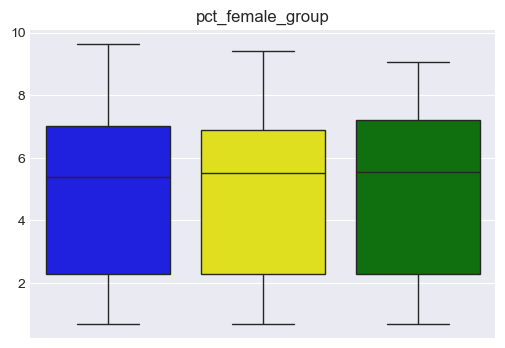

In [1409]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='female_group', y='log_median_dwell', data=combined_data_female, palette=female_palette,hue='female_group')
plt.title('pct_female_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_female_group_dw.png',dpi=300)

## 21) Age: Young

In [1410]:
merged_young_dw = merged_df[['FIPS','pct_young','median_dwell']]
merged_young_ranked = merged_young_dw.sort_values('pct_young')

In [1411]:
pct_low_young = merged_young_ranked.head(1267)
pct_moderate_young = merged_young_ranked.iloc[1267:2535]
pct_high_young = merged_young_ranked.iloc[2536:3804]

In [1412]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_young_dw = pct_low_young['median_dwell'].mean()
pct_mean_visits_moderate_young_dw = pct_moderate_young['median_dwell'].mean()
pct_mean_visits_high_young_dw = pct_high_young['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_young: {pct_mean_visits_low_young_dw}')
print(f'Mean park dwell time for pct_moderate_young: {pct_mean_visits_moderate_young_dw}')
print(f'Mean park dwell time for pct_high_young: {pct_mean_visits_high_young_dw}')

Mean park dwell time for pct_low_young: 784.3725335438043
Mean park dwell time for pct_moderate_young: 641.9345425867508
Mean park dwell time for pct_high_young: 841.1419558359621


In [1413]:
# perform One_way ANOVA

anova_result_young = f_oneway(pct_low_young['median_dwell'], pct_moderate_young['median_dwell'],pct_high_young['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_young.statistic}")
print(f"ANOVA p-value: {anova_result_young.pvalue}")

ANOVA F-value: 9.710763528564167
ANOVA p-value: 6.21454935528012e-05


In [1414]:
# Step 1: Combine data into a single DataFrame
combined_data_young = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_young['median_dwell'], 
        pct_moderate_young['median_dwell'], 
        pct_high_young['median_dwell']
    ], ignore_index=True),
    'young_group': ['pct_low_young'] * len(pct_low_young) + 
                    ['pct_moderate_young'] * len(pct_moderate_young) + 
                    ['pct_high_young'] * len(pct_high_young)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_young['median_dwell'],
                                  groups=combined_data_young['young_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
    group1           group2        meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------------
pct_high_young      pct_low_young  -56.7694 0.4422 -165.9903  52.4514  False
pct_high_young pct_moderate_young -199.2074 0.0001 -308.4067 -90.0081   True
 pct_low_young pct_moderate_young  -142.438 0.0064 -251.6588 -33.2171   True
----------------------------------------------------------------------------


In [1415]:
# Apply log transformation to the visits_by_cbg column
combined_data_young['log_median_dwell'] = np.log(combined_data_young['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
young_palette = {'pct_low_young': 'blue', 'pct_moderate_young': 'yellow', 'pct_high_young': 'green'}

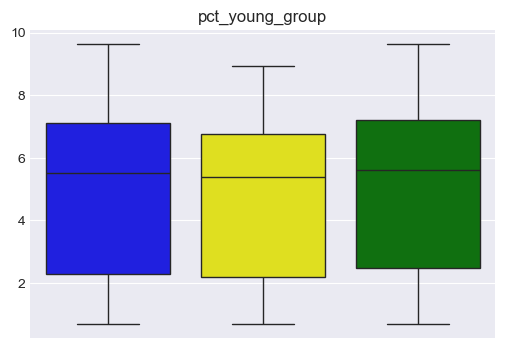

In [1416]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='young_group', y='log_median_dwell', data=combined_data_young, palette=young_palette,hue='young_group')
plt.title('pct_young_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_young_group_dw.png',dpi=300)

## 22) Age: Adult

In [1417]:
merged_adult_dw = merged_df[['FIPS','pct_adult','median_dwell']]
merged_adult_ranked = merged_adult_dw.sort_values('pct_adult')

In [1418]:
pct_low_adult = merged_adult_ranked.head(1267)
pct_moderate_adult = merged_adult_ranked.iloc[1267:2535]
pct_high_adult = merged_adult_ranked.iloc[2536:3804]

In [1419]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_adult_dw = pct_low_adult['median_dwell'].mean()
pct_mean_visits_moderate_adult_dw = pct_moderate_adult['median_dwell'].mean()
pct_mean_visits_high_adult_dw = pct_high_adult['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_adult: {pct_mean_visits_low_adult_dw}')
print(f'Mean park dwell time for pct_moderate_adult: {pct_mean_visits_moderate_adult_dw}')
print(f'Mean park dwell time for pct_high_adult: {pct_mean_visits_high_adult_dw}')

Mean park dwell time for pct_low_adult: 838.423046566693
Mean park dwell time for pct_moderate_adult: 707.0828075709779
Mean park dwell time for pct_high_adult: 721.9865930599369


In [1420]:
# perform One_way ANOVA

anova_result_adult = f_oneway(pct_low_adult['median_dwell'], pct_moderate_adult['median_dwell'],pct_high_adult['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_adult.statistic}")
print(f"ANOVA p-value: {anova_result_adult.pvalue}")

ANOVA F-value: 4.7534507403703214
ANOVA p-value: 0.008673225657465913


In [1421]:
# Step 1: Combine data into a single DataFrame
combined_data_adult = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_adult['median_dwell'], 
        pct_moderate_adult['median_dwell'], 
        pct_high_adult['median_dwell']
    ], ignore_index=True),
    'adult_group': ['pct_low_adult'] * len(pct_low_adult) + 
                    ['pct_moderate_adult'] * len(pct_moderate_adult) + 
                    ['pct_high_adult'] * len(pct_high_adult)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_adult['median_dwell'],
                                  groups=combined_data_adult['adult_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
    group1           group2        meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------------
pct_high_adult      pct_low_adult  116.4365 0.0337    7.0736 225.7993   True
pct_high_adult pct_moderate_adult  -14.9038 0.9453 -124.2451  94.4375  False
 pct_low_adult pct_moderate_adult -131.3402 0.0136 -240.7031 -21.9774   True
----------------------------------------------------------------------------


In [1422]:
# Apply log transformation to the visits_by_cbg column
combined_data_adult['log_median_dwell'] = np.log(combined_data_adult['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
adult_palette = {'pct_low_adult': 'blue', 'pct_moderate_adult': 'yellow', 'pct_high_adult': 'green'}

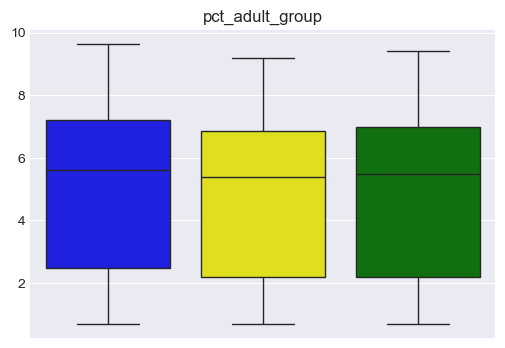

In [1423]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='adult_group', y='log_median_dwell', data=combined_data_adult, palette=adult_palette,hue='adult_group')
plt.title('pct_adult_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_adult_group_dw.png',dpi=300)

## 23) Age: Elderly

In [1424]:
merged_elderly_dw = merged_df[['FIPS','pct_elderly','median_dwell']]
merged_elderly_ranked = merged_elderly_dw.sort_values('pct_elderly')

In [1425]:
pct_low_elderly = merged_elderly_ranked.head(1267)
pct_moderate_elderly = merged_elderly_ranked.iloc[1267:2535]
pct_high_elderly = merged_elderly_ranked.iloc[2535:3804]

In [1426]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_elderly_dw = pct_low_elderly['median_dwell'].mean()
pct_mean_visits_moderate_elderly_dw = pct_moderate_elderly['median_dwell'].mean()
pct_mean_visits_high_elderly_dw = pct_high_elderly['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_elderly: {pct_mean_visits_low_elderly_dw}')
print(f'Mean park dwell time for pct_moderate_elderly: {pct_mean_visits_moderate_elderly_dw}')
print(f'Mean park dwell time for pct_high_elderly: {pct_mean_visits_high_elderly_dw}')

Mean park dwell time for pct_low_elderly: 839.2983425414365
Mean park dwell time for pct_moderate_elderly: 665.3872239747634
Mean park dwell time for pct_high_elderly: 762.2072498029945


In [1427]:
# perform One_way ANOVA

anova_result_elderly = f_oneway(pct_low_elderly['median_dwell'], pct_moderate_elderly['median_dwell'],pct_high_elderly['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_elderly.statistic}")
print(f"ANOVA p-value: {anova_result_elderly.pvalue}")

ANOVA F-value: 6.990046516024212
ANOVA p-value: 0.000932890021987658


In [1428]:
# Step 1: Combine data into a single DataFrame
combined_data_elderly = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_elderly['median_dwell'], 
        pct_moderate_elderly['median_dwell'], 
        pct_high_elderly['median_dwell']
    ], ignore_index=True),
    'elderly_group': ['pct_low_elderly'] * len(pct_low_elderly) + 
                    ['pct_moderate_elderly'] * len(pct_moderate_elderly) + 
                    ['pct_high_elderly'] * len(pct_high_elderly)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_elderly['median_dwell'],
                                  groups=combined_data_elderly['elderly_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1             group2         meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------------
pct_high_elderly      pct_low_elderly   77.0911 0.2232  -32.1777 186.3599  False
pct_high_elderly pct_moderate_elderly    -96.82 0.0946 -206.0673  12.4272  False
 pct_low_elderly pct_moderate_elderly -173.9111 0.0006 -283.2014 -64.6208   True
--------------------------------------------------------------------------------


In [1431]:
# Apply log transformation to the visits_by_cbg column
combined_data_elderly['log_median_dwell'] = np.log(combined_data_elderly['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
elderly_palette = {'pct_low_elderly': 'blue', 'pct_moderate_elderly': 'yellow', 'pct_high_elderly': 'green'}

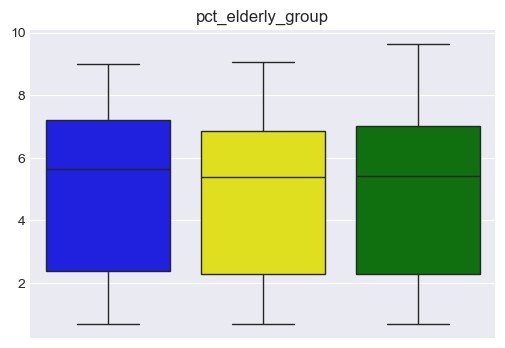

In [1432]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='elderly_group', y='log_median_dwell', data=combined_data_elderly, palette=elderly_palette,hue='elderly_group')
plt.title('pct_elderly_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_elderly_group_dw.png',dpi=300)

## 24) Education: less high sch

In [1433]:
merged_lessHigh_dw = merged_df[['FIPS','pct_low_edu','median_dwell']]
merged_lessHigh_ranked = merged_lessHigh_dw.sort_values('pct_low_edu')

In [1434]:
pct_low_lessHigh = merged_lessHigh_ranked.head(1267)
pct_moderate_lessHigh = merged_lessHigh_ranked.iloc[1267:2535]
pct_high_lessHigh = merged_lessHigh_ranked.iloc[2536:3804]

In [1435]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_lessHigh_dw = pct_low_lessHigh['median_dwell'].mean()
pct_mean_visits_moderate_lessHigh_dw = pct_moderate_lessHigh['median_dwell'].mean()
pct_mean_visits_high_lessHigh_dw = pct_high_lessHigh['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_lessHigh: {pct_mean_visits_low_lessHigh_dw}')
print(f'Mean park dwell time for pct_moderate_lessHigh: {pct_mean_visits_moderate_lessHigh_dw}')
print(f'Mean park dwell time for pct_high_lessHigh: {pct_mean_visits_high_lessHigh_dw}')

Mean park dwell time for pct_low_lessHigh: 972.7150749802684
Mean park dwell time for pct_moderate_lessHigh: 591.5465299684543
Mean park dwell time for pct_high_lessHigh: 703.3351735015773


In [1436]:
# perform One_way ANOVA

anova_result_lessHigh = f_oneway(pct_low_lessHigh['median_dwell'], pct_moderate_lessHigh['median_dwell'],pct_high_lessHigh['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_lessHigh.statistic}")
print(f"ANOVA p-value: {anova_result_lessHigh.pvalue}")

ANOVA F-value: 35.86520018075516
ANOVA p-value: 3.707894550886268e-16


In [1437]:
# Step 1: Combine data into a single DataFrame
combined_data_lessHigh = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_lessHigh['median_dwell'], 
        pct_moderate_lessHigh['median_dwell'], 
        pct_high_lessHigh['median_dwell']
    ], ignore_index=True),
    'lessHigh_group': ['pct_low_lessHigh'] * len(pct_low_lessHigh) + 
                    ['pct_moderate_lessHigh'] * len(pct_moderate_lessHigh) + 
                    ['pct_high_lessHigh'] * len(pct_high_lessHigh)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_lessHigh['median_dwell'],
                                  groups=combined_data_lessHigh['lessHigh_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
      group1              group2         meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------------------
pct_high_lessHigh      pct_low_lessHigh  269.3799    0.0  160.8994 377.8605   True
pct_high_lessHigh pct_moderate_lessHigh -111.7886 0.0416 -220.2478  -3.3295   True
 pct_low_lessHigh pct_moderate_lessHigh -381.1685    0.0 -489.6491 -272.688   True
----------------------------------------------------------------------------------


In [1438]:
# Apply log transformation to the visits_by_cbg column
combined_data_lessHigh['log_median_dwell'] = np.log(combined_data_lessHigh['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
lessHigh_palette = {'pct_low_lessHigh': 'blue', 'pct_moderate_lessHigh': 'yellow', 'pct_high_lessHigh': 'green'}

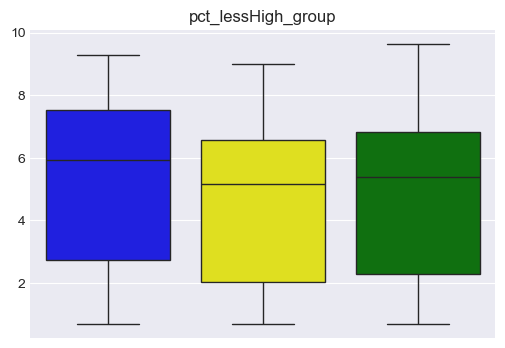

In [1439]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='lessHigh_group', y='log_median_dwell', data=combined_data_lessHigh, palette=lessHigh_palette,hue='lessHigh_group')
plt.title('pct_lessHigh_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_lessHigh_group_dw.png',dpi=300)

## 25) Education: high school

In [1440]:
merged_highsch_dw = merged_df[['FIPS','pct_high_edu','median_dwell']]
merged_highsch_ranked = merged_highsch_dw.sort_values('pct_high_edu')

In [1441]:
pct_low_highsch = merged_highsch_ranked.head(1267)
pct_moderate_highsch = merged_highsch_ranked.iloc[1267:2535]
pct_high_highsch = merged_highsch_ranked.iloc[2536:3804]

In [1442]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_High_dw = pct_low_highsch['median_dwell'].mean()
pct_mean_visits_moderate_High_dw = pct_moderate_highsch['median_dwell'].mean()
pct_mean_visits_high_High_dw = pct_high_highsch['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_High: {pct_mean_visits_low_High_dw}')
print(f'Mean park dwell time for pct_moderate_High: {pct_mean_visits_moderate_High_dw}')
print(f'Mean park dwell time for pct_high_High: {pct_mean_visits_high_High_dw}')

Mean park dwell time for pct_low_High: 702.8847671665351
Mean park dwell time for pct_moderate_High: 592.3966876971609
Mean park dwell time for pct_high_High: 971.9503154574132


In [1443]:
# perform One_way ANOVA

anova_result_highsch = f_oneway(pct_low_highsch['median_dwell'], pct_moderate_highsch['median_dwell'],pct_high_highsch['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_highsch.statistic}")
print(f"ANOVA p-value: {anova_result_highsch.pvalue}")

ANOVA F-value: 35.612370284605575
ANOVA p-value: 4.752288095672643e-16


In [1444]:
# Step 1: Combine data into a single DataFrame
combined_data_highsch = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_highsch['median_dwell'], 
        pct_moderate_highsch['median_dwell'], 
        pct_high_highsch['median_dwell']
    ], ignore_index=True),
    'highsch_group': ['pct_low_highsch'] * len(pct_low_highsch) + 
                    ['pct_moderate_highsch'] * len(pct_moderate_highsch) + 
                    ['pct_high_highsch'] * len(pct_high_highsch)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_highsch['median_dwell'],
                                  groups=combined_data_highsch['highsch_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1             group2         meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------------------
pct_high_highsch      pct_low_highsch -269.0655    0.0 -377.5558 -160.5753   True
pct_high_highsch pct_moderate_highsch -379.5536    0.0 -488.0225 -271.0848   True
 pct_low_highsch pct_moderate_highsch -110.4881 0.0448 -218.9783   -1.9978   True
---------------------------------------------------------------------------------


In [1445]:
# Apply log transformation to the visits_by_cbg column
combined_data_highsch['log_median_dwell'] = np.log(combined_data_highsch['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
highsch_palette = {'pct_low_highsch': 'blue', 'pct_moderate_highsch': 'yellow', 'pct_high_highsch': 'green'}

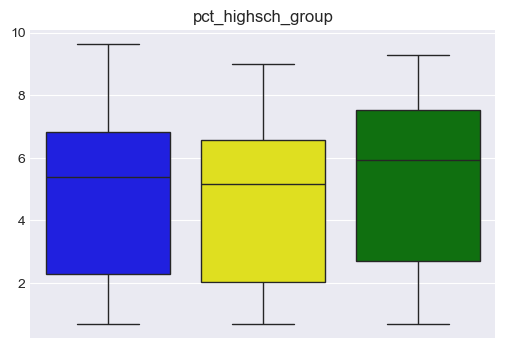

In [1446]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='highsch_group', y='log_median_dwell', data=combined_data_highsch, palette=highsch_palette,hue='highsch_group')
plt.title('pct_highsch_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_highsch_group_dw.png',dpi=300)

## 26) Transport: Car

In [1447]:
merged_car_dw = merged_df[['FIPS','pct_car','median_dwell']]
merged_car_ranked = merged_car_dw.sort_values('pct_car')

In [1448]:
pct_low_car = merged_car_ranked.head(1267)
pct_moderate_car = merged_car_ranked.iloc[1267:2535]
pct_high_car = merged_car_ranked.iloc[2536:3804]

In [1449]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_car_dw = pct_low_car['median_dwell'].mean()
pct_mean_visits_moderate_car_dw = pct_moderate_car['median_dwell'].mean()
pct_mean_visits_high_car_dw = pct_high_car['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_car: {pct_mean_visits_low_car_dw}')
print(f'Mean park dwell time for pct_moderate_car: {pct_mean_visits_moderate_car_dw}')
print(f'Mean park dwell time for pct_high_car: {pct_mean_visits_high_car_dw}')

Mean park dwell time for pct_low_car: 1236.6969218626678
Mean park dwell time for pct_moderate_car: 693.2689274447949
Mean park dwell time for pct_high_car: 337.66719242902207


In [1450]:
# perform One_way ANOVA

anova_result_car = f_oneway(pct_low_car['median_dwell'], pct_moderate_car['median_dwell'],pct_high_car['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_car.statistic}")
print(f"ANOVA p-value: {anova_result_car.pvalue}")

ANOVA F-value: 208.59606158042195
ANOVA p-value: 1.1076406601951e-86


In [1451]:
# Step 1: Combine data into a single DataFrame
combined_data_car = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_car['median_dwell'], 
        pct_moderate_car['median_dwell'], 
        pct_high_car['median_dwell']
    ], ignore_index=True),
    'car_group': ['pct_low_car'] * len(pct_low_car) + 
                    ['pct_moderate_car'] * len(pct_moderate_car) + 
                    ['pct_high_car'] * len(pct_high_car)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_car['median_dwell'],
                                  groups=combined_data_car['car_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1         group2      meandiff p-adj   lower     upper   reject
-----------------------------------------------------------------------
pct_high_car      pct_low_car 899.0297   0.0  795.0846 1002.9749   True
pct_high_car pct_moderate_car 355.6017   0.0  251.6771  459.5264   True
 pct_low_car pct_moderate_car -543.428   0.0 -647.3732 -439.4828   True
-----------------------------------------------------------------------


In [1452]:
# Apply log transformation to the visits_by_cbg column
combined_data_car['log_median_dwell'] = np.log(combined_data_car['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
car_palette = {'pct_low_car': 'blue', 'pct_moderate_car': 'yellow', 'pct_high_car': 'green'}

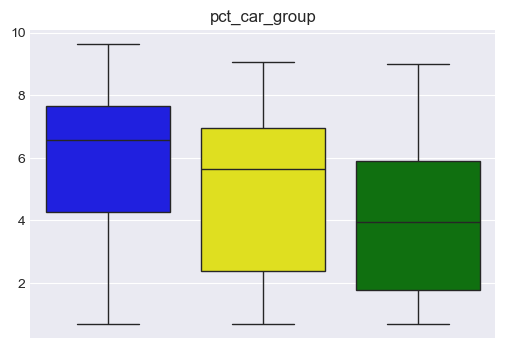

In [1453]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='car_group', y='log_median_dwell', data=combined_data_car, palette=car_palette,hue='car_group')
plt.title('pct_car_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_car_group_dw.png',dpi=300)

## 28) Transport : 0car

In [1454]:
merged_0car_dw = merged_df[['FIPS','pct_0car','median_dwell']]
merged_0car_ranked = merged_0car_dw.sort_values('pct_0car')

In [1455]:
pct_low_0car = merged_0car_ranked.head(1267)
pct_moderate_0car = merged_0car_ranked.iloc[1267:2535]
pct_high_0car = merged_0car_ranked.iloc[1267:2535]

In [1456]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_0car_dw = pct_low_0car['median_dwell'].mean()
pct_mean_visits_moderate_0car_dw = pct_moderate_0car['median_dwell'].mean()
pct_mean_visits_high_0car_dw = pct_high_0car['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_0car: {pct_mean_visits_low_0car_dw}')
print(f'Mean park dwell time for pct_moderate_0car: {pct_mean_visits_moderate_0car_dw}')
print(f'Mean park dwell time for pct_high_0car: {pct_mean_visits_high_0car_dw}')

Mean park dwell time for pct_low_0car: 502.13891081294395
Mean park dwell time for pct_moderate_0car: 607.9763406940064
Mean park dwell time for pct_high_0car: 607.9763406940064


In [1457]:
# perform One_way ANOVA

anova_result_0car = f_oneway(pct_low_0car['median_dwell'], pct_moderate_0car['median_dwell'],pct_high_0car['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_0car.statistic}")
print(f"ANOVA p-value: {anova_result_0car.pvalue}")

ANOVA F-value: 5.4547819756640115
ANOVA p-value: 0.0043093561982246184


In [1458]:
# Step 1: Combine data into a single DataFrame
combined_data_0car = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_0car['median_dwell'], 
        pct_moderate_0car['median_dwell'], 
        pct_high_0car['median_dwell']
    ], ignore_index=True),
    '0car_group': ['pct_low_0car'] * len(pct_low_0car) + 
                    ['pct_moderate_0car'] * len(pct_moderate_0car) + 
                    ['pct_high_0car'] * len(pct_high_0car)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_0car['median_dwell'],
                                  groups=combined_data_0car['0car_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1          group2       meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------
pct_high_0car      pct_low_0car -105.8374 0.0118 -192.5834 -19.0915   True
pct_high_0car pct_moderate_0car       0.0    1.0  -86.7288  86.7288  False
 pct_low_0car pct_moderate_0car  105.8374 0.0118   19.0915 192.5834   True
--------------------------------------------------------------------------


In [1459]:
# Apply log transformation to the visits_by_cbg column
combined_data_0car['log_median_dwell'] = np.log(combined_data_0car['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Zcar_palette = {'pct_low_0car': 'blue', 'pct_moderate_0car': 'yellow', 'pct_high_0car': 'green'}

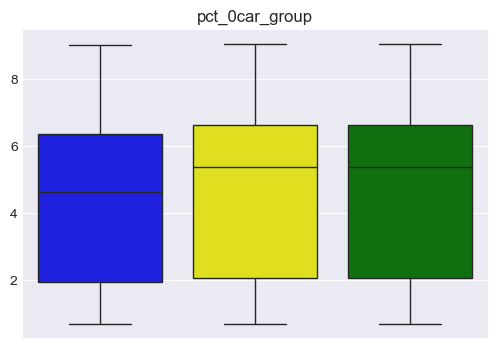

In [1460]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='0car_group', y='log_median_dwell', data=combined_data_0car, palette=Zcar_palette,hue='0car_group')
plt.title('pct_0car_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_0car_group_dw.png',dpi=300)

## 29) Transport: Public Transit

In [1461]:
merged_public_trans_dw = merged_df[['FIPS','pct_public_trans','median_dwell']]
merged_public_trans_ranked = merged_public_trans_dw.sort_values('pct_public_trans')

In [1462]:
pct_low_public_trans = merged_public_trans_ranked.head(1267)
pct_moderate_public_trans = merged_public_trans_ranked.iloc[1267:2535]
pct_high_public_trans = merged_public_trans_ranked.iloc[2536:3804]

In [1463]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_public_trans_dw = pct_low_public_trans['median_dwell'].mean()
pct_mean_visits_moderate_public_trans_dw = pct_moderate_public_trans['median_dwell'].mean()
pct_mean_visits_high_public_trans_dw = pct_high_public_trans['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_public_trans: {pct_mean_visits_low_public_trans_dw}')
print(f'Mean park dwell time for pct_moderate_public_trans: {pct_mean_visits_moderate_public_trans_dw}')
print(f'Mean park dwell time for pct_high_public_trans: {pct_mean_visits_high_public_trans_dw}')

Mean park dwell time for pct_low_public_trans: 513.1018153117601
Mean park dwell time for pct_moderate_public_trans: 871.8296529968454
Mean park dwell time for pct_high_public_trans: 880.9944794952681


In [1464]:
# perform One_way ANOVA

anova_result_public_trans = f_oneway(pct_low_public_trans['median_dwell'], pct_moderate_public_trans['median_dwell'],pct_high_public_trans['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_public_trans.statistic}")
print(f"ANOVA p-value: {anova_result_public_trans.pvalue}")

ANOVA F-value: 41.23635697876595
ANOVA p-value: 1.9180080104925546e-18


In [1465]:
# Step 1: Combine data into a single DataFrame
combined_data_public_trans = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_public_trans['median_dwell'], 
        pct_moderate_public_trans['median_dwell'], 
        pct_high_public_trans['median_dwell']
    ], ignore_index=True),
    'public_trans_group': ['pct_low_public_trans'] * len(pct_low_public_trans) + 
                    ['pct_moderate_public_trans'] * len(pct_moderate_public_trans) + 
                    ['pct_high_public_trans'] * len(pct_high_public_trans)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_public_trans['median_dwell'],
                                  groups=combined_data_public_trans['public_trans_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
        group1                  group2           meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------------------------------
pct_high_public_trans      pct_low_public_trans -367.8927    0.0 -476.2204 -259.5649   True
pct_high_public_trans pct_moderate_public_trans   -9.1648 0.9785 -117.4712   99.1415  False
 pct_low_public_trans pct_moderate_public_trans  358.7278    0.0  250.4001  467.0556   True
-------------------------------------------------------------------------------------------


In [1466]:
# Apply log transformation to the visits_by_cbg column
combined_data_public_trans['log_median_dwell'] = np.log(combined_data_public_trans['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
public_trans_palette = {'pct_low_public_trans': 'blue', 'pct_moderate_public_trans': 'yellow', 'pct_high_public_trans': 'green'}

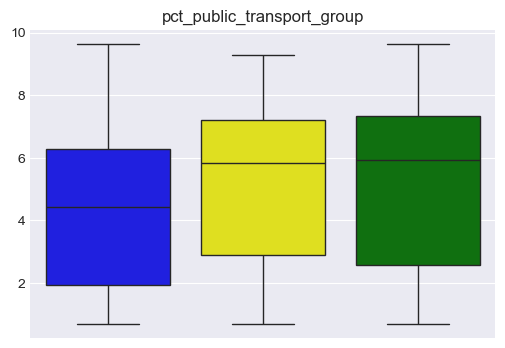

In [1467]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='public_trans_group', y='log_median_dwell', data=combined_data_public_trans, palette=public_trans_palette,hue='public_trans_group')
plt.title('pct_public_transport_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_public_trans_group_dw.png',dpi=300)

## 30) Commute: Short

In [1468]:
merged_short_commute_dw = merged_df[['FIPS','pct_short_comute','median_dwell']]
merged_short_commute_ranked = merged_short_commute_dw.sort_values('pct_short_comute')

In [1469]:
pct_low_Scomute = merged_short_commute_ranked.head(1267)
pct_moderate_Scomute = merged_short_commute_ranked.iloc[1267:2535]
pct_high_Scomute = merged_short_commute_ranked.iloc[2536:3804]

In [1470]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_Scommute_dw = pct_low_Scomute['median_dwell'].mean()
pct_mean_visits_moderate_Scommute_dw = pct_moderate_Scomute['median_dwell'].mean()
pct_mean_visits_high_Scommute_dw = pct_high_Scomute['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_Scommute: {pct_mean_visits_low_Scommute_dw}')
print(f'Mean park dwell time for pct_moderate_Scommute: {pct_mean_visits_moderate_Scommute_dw}')
print(f'Mean park dwell time for pct_high_Scommute: {pct_mean_visits_high_Scommute_dw}')

Mean park dwell time for pct_low_Scommute: 511.25256511444354
Mean park dwell time for pct_moderate_Scommute: 565.0938485804417
Mean park dwell time for pct_high_Scommute: 1189.2011041009464


In [1471]:
# perform One_way ANOVA

anova_result_Scomute = f_oneway(pct_low_Scomute['median_dwell'], pct_moderate_Scomute['median_dwell'],pct_high_Scomute['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_Scomute.statistic}")
print(f"ANOVA p-value: {anova_result_Scomute.pvalue}")

ANOVA F-value: 139.86505909500698
ANOVA p-value: 2.4496709247601357e-59


In [1472]:
# Step 1: Combine data into a single DataFrame
combined_data_Scomute = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_Scomute['median_dwell'], 
        pct_moderate_Scomute['median_dwell'], 
        pct_high_Scomute['median_dwell']
    ], ignore_index=True),
    'Scomute_group': ['pct_low_Scomute'] * len(pct_low_Scomute) + 
                    ['pct_moderate_Scomute'] * len(pct_moderate_Scomute) + 
                    ['pct_high_Scomute'] * len(pct_high_Scomute)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_Scomute['median_dwell'],
                                  groups=combined_data_Scomute['Scomute_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1             group2         meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------------------
pct_high_Scomute      pct_low_Scomute -677.9485    0.0  -783.614 -572.2831   True
pct_high_Scomute pct_moderate_Scomute -624.1073    0.0 -729.7518 -518.4627   True
 pct_low_Scomute pct_moderate_Scomute   53.8413 0.4564  -51.8241  159.5067  False
---------------------------------------------------------------------------------


In [1473]:
# Apply log transformation to the visits_by_cbg column
combined_data_Scomute['log_median_dwell'] = np.log(combined_data_Scomute['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Scomute_palette = {'pct_low_Scomute': 'blue', 'pct_moderate_Scomute': 'yellow', 'pct_high_Scomute': 'green'}

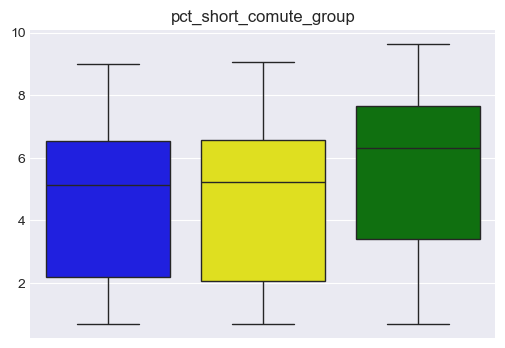

In [1474]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='Scomute_group', y='log_median_dwell', data=combined_data_Scomute, palette=Scomute_palette,hue='Scomute_group')
plt.title('pct_short_comute_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_Scomute_group_dw.png',dpi=300)

## 31) Commute: Long

In [1475]:
merged_Lcomute_dw = merged_df[['FIPS','pct_long_comute','median_dwell']]
merged_Lcomute_ranked = merged_Lcomute_dw.sort_values('pct_long_comute')

In [1476]:
pct_low_Lcomute = merged_Lcomute_ranked.head(1267)
pct_moderate_Lcomute =merged_Lcomute_ranked.iloc[1267:2535]
pct_high_Lcomute = merged_Lcomute_ranked.iloc[2536:3804]

In [1477]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_Lcommute_dw = pct_low_Lcomute['median_dwell'].mean()
pct_mean_visits_moderate_Lcommute_dw = pct_moderate_Lcomute['median_dwell'].mean()
pct_mean_visits_high_Lcommute_dw = pct_high_Lcomute['median_dwell'].mean()

print(f'Mean park dwell time for pct_low_Lcommute: {pct_mean_visits_low_Lcommute_dw}')
print(f'Mean park dwell time for pct_moderate_Lcommute: {pct_mean_visits_moderate_Lcommute_dw}')
print(f'Mean park dwell time for pct_high_Lcommute: {pct_mean_visits_high_Lcommute_dw}')

Mean park dwell time for pct_low_Lcommute: 1190.136543014996
Mean park dwell time for pct_moderate_Lcommute: 565.9518927444796
Mean park dwell time for pct_high_Lcommute: 511.10804416403784


In [1478]:
# perform One_way ANOVA

anova_result_Lcomute = f_oneway(pct_low_Lcomute['median_dwell'], pct_moderate_Lcomute['median_dwell'],pct_high_Lcomute['median_dwell'])

# Print the results
print(f"ANOVA F-value: {anova_result_Lcomute.statistic}")
print(f"ANOVA p-value: {anova_result_Lcomute.pvalue}")

ANOVA F-value: 140.05087092475273
ANOVA p-value: 2.0603793069526577e-59


In [1479]:
# Step 1: Combine data into a single DataFrame
combined_data_Lcomute = pd.DataFrame({
    'median_dwell': pd.concat([
        pct_low_Lcomute['median_dwell'], 
        pct_moderate_Lcomute['median_dwell'], 
        pct_high_Lcomute['median_dwell']
    ], ignore_index=True),
    'Lcomute_group': ['pct_low_Lcomute'] * len(pct_low_Lcomute) + 
                    ['pct_moderate_Lcomute'] * len(pct_moderate_Lcomute) + 
                    ['pct_high_Lcomute'] * len(pct_high_Lcomute)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_Lcomute['median_dwell'],
                                  groups=combined_data_Lcomute['Lcomute_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1             group2         meandiff p-adj    lower     upper   reject
---------------------------------------------------------------------------------
pct_high_Lcomute      pct_low_Lcomute  679.0285    0.0  573.3486  784.7084   True
pct_high_Lcomute pct_moderate_Lcomute   54.8438 0.4431  -50.8152  160.5029  False
 pct_low_Lcomute pct_moderate_Lcomute -624.1847    0.0 -729.8645 -518.5048   True
---------------------------------------------------------------------------------


In [1480]:
# Apply log transformation to the visits_by_cbg column
combined_data_Lcomute['log_median_dwell'] = np.log(combined_data_Lcomute['median_dwell'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Lcomute_palette = {'pct_low_Lcomute': 'blue', 'pct_moderate_Lcomute': 'yellow', 'pct_high_Lcomute': 'green'}

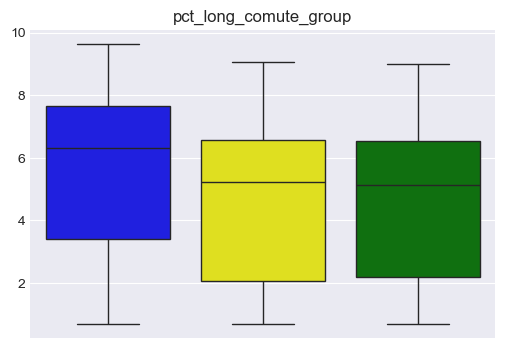

In [1481]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='Lcomute_group', y='log_median_dwell', data=combined_data_Lcomute, palette=Lcomute_palette,hue='Lcomute_group')
plt.title('pct_long_comute_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_Lcommute_group_dw.png',dpi=300)

# Does socioeconomic factors influence how far people TRAVEL to parks in NYC?

## 32) Income category

In [1482]:
merged_income_dt = merged_df[['FIPS','median_income','distance_from_home']]
merged_income_ranked = merged_income_dt.sort_values('median_income')

In [1484]:
pct_low_income = merged_income_ranked.head(1267)
pct_median_income = merged_income_ranked.iloc[1267:2535]
pct_high_income = merged_income_ranked.iloc[2536:3804]

In [1485]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_income_dt = pct_low_income['distance_from_home'].mean()
pct_mean_visits_moderate_income_dt = pct_median_income['distance_from_home'].mean()
pct_mean_visits_high_income_dt = pct_high_income['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_income: {pct_mean_visits_low_income_dt}')
print(f'Mean travel distance for pct_moderate_income: {pct_mean_visits_moderate_income_dt}')
print(f'Mean travel distance for pct_high_income: {pct_mean_visits_high_income_dt}')

Mean travel distance for pct_low_income: 280268.8397790055
Mean travel distance for pct_moderate_income: 253983.1119873817
Mean travel distance for pct_high_income: 405641.1593059937


In [1486]:
# perform One_way ANOVA

anova_result_income= f_oneway(pct_low_income['distance_from_home'], pct_median_income['distance_from_home'],pct_high_income['distance_from_home'])
# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 53.90879902880987
ANOVA p-value: 8.1977254017573e-24


In [1487]:
# Step 1: Combine data into a single DataFrame
combined_data = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_income['distance_from_home'], 
        pct_median_income['distance_from_home'], 
        pct_high_income['distance_from_home']
    ], ignore_index=True),
    'income_group': ['pct_low_income'] * len(pct_low_income) + 
                    ['pct_median_income'] * len(pct_median_income) + 
                    ['pct_high_income'] * len(pct_high_income)
})
# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data['distance_from_home'],
                                  groups=combined_data['income_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
     group1           group2        meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------------------
pct_high_income    pct_low_income -125372.3195    0.0 -161978.3935  -88766.2455   True
pct_high_income pct_median_income -151658.0473    0.0 -188256.9005 -115059.1941   True
 pct_low_income pct_median_income  -26285.7278 0.2116  -62891.8018   10320.3462  False
--------------------------------------------------------------------------------------


In [1488]:
# Apply log transformation to the visits_by_cbg column
combined_data['log_distance'] = np.log(combined_data['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
income_palette = {'pct_low_income': 'blue', 'pct_median_income': 'yellow', 'pct_high_income': 'green'}

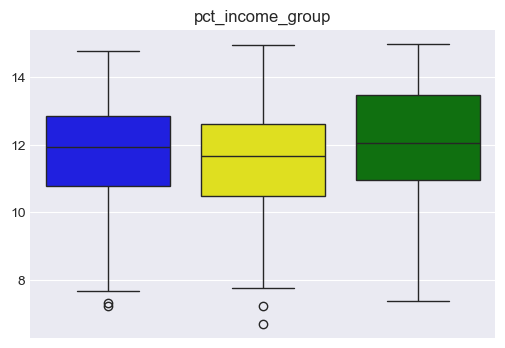

In [1489]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='income_group', y='log_distance', data=combined_data, palette=income_palette,hue='income_group')
plt.title('pct_income_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_income_group_dt.png',dpi=300)

## 33) Black

In [1490]:
merged_race_dt = merged_df[['FIPS','pct_black','distance_from_home']]
merged_race_ranked = merged_race_dt.sort_values('pct_black')

In [1491]:
pct_low_black = merged_race_ranked.head(1268)
pct_moderate_black = merged_race_ranked.iloc[1267:2535]
pct_high_black = merged_race_ranked.iloc[2536:3804]

In [1492]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_black_dt = pct_low_black['distance_from_home'].mean()
pct_mean_visits_moderate_black_dt = pct_moderate_black['distance_from_home'].mean()
pct_mean_visits_high_black_dt = pct_high_black['distance_from_home'].mean()

print(f'Mean travel distance for pct_black_income: {pct_mean_visits_low_black_dt}')
print(f'Mean travel distance for pct_moderate_black_dwell: {pct_mean_visits_moderate_black_dt}')
print(f'Mean travel distance for pct_high_black_dwell: {pct_mean_visits_high_black_dt}')

Mean travel distance for pct_black_income: 369017.76498422713
Mean travel distance for pct_moderate_black_dwell: 349450.79022082017
Mean travel distance for pct_high_black_dwell: 221280.43375394322


In [1493]:
# perform One_way ANOVA

anova_result_black = f_oneway(pct_low_black['distance_from_home'], pct_moderate_black['distance_from_home'],pct_high_black['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_black.statistic}")
print(f"ANOVA p-value: {anova_result_black.pvalue}")

ANOVA F-value: 52.83599779074155
ANOVA p-value: 2.3269867684877364e-23


In [1494]:
# Step 1: Combine data into a single DataFrame
combined_data_black = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_black['distance_from_home'], 
        pct_moderate_black['distance_from_home'], 
        pct_high_black['distance_from_home']
    ], ignore_index=True),
    'black_group': ['pct_low_black'] * len(pct_low_black) + 
                    ['pct_moderate_black'] * len(pct_moderate_black) + 
                    ['pct_high_black'] * len(pct_high_black)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_black['distance_from_home'],
                                  groups=combined_data_black['black_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1           group2         meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------------------------
pct_high_black      pct_low_black 147737.3312    0.0 111131.7108 184342.9516   True
pct_high_black pct_moderate_black 128170.3565    0.0  91564.7361 164775.9769   True
 pct_low_black pct_moderate_black -19566.9748 0.4219 -56172.5952  17038.6456  False
-----------------------------------------------------------------------------------


In [1495]:
# Apply log transformation to the visits_by_cbg column
combined_data_black['log_distance'] = np.log(combined_data_black['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
black_palette = {'pct_low_black': 'blue', 'pct_moderate_black': 'yellow', 'pct_high_black': 'green'}

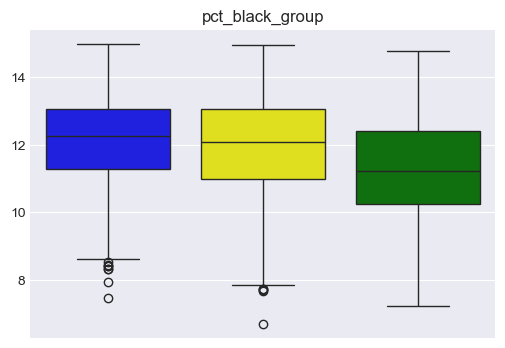

In [1496]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='black_group', y='log_distance', data=combined_data_black, palette=black_palette,hue='black_group')
plt.title('pct_black_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_black_group_dt.png',dpi=300)

## 34) Asian

In [1497]:
merged_asian_dt = merged_df[['FIPS','pct_asian','distance_from_home']]
merged_asian_ranked = merged_asian_dt.sort_values('pct_asian')

In [1498]:
pct_low_asian = merged_asian_ranked.head(1267)
pct_moderate_asian = merged_asian_ranked.iloc[1267:2535]
pct_high_asian = merged_asian_ranked.iloc[2536:3804]

In [1499]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_asian_dt = pct_low_asian['distance_from_home'].mean()
pct_mean_visits_moderate_asian_dt = pct_moderate_asian['distance_from_home'].mean()
pct_mean_visits_high_asian_dt = pct_high_asian['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_asian: {pct_mean_visits_low_asian_dt}')
print(f'Mean travel distance for pct_moderate_asian: {pct_mean_visits_moderate_asian_dt}')
print(f'Mean travel distance for pct_high_asian: {pct_mean_visits_high_asian_dt}')

Mean travel distance for pct_low_asian: 243643.136543015
Mean travel distance for pct_moderate_asian: 337072.04810725554
Mean travel distance for pct_high_asian: 359145.9668769716


In [1500]:
# perform One_way ANOVA

anova_result_asian = f_oneway(pct_low_asian['distance_from_home'], pct_moderate_asian['distance_from_home'],pct_high_asian['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_asian.statistic}")
print(f"ANOVA p-value: {anova_result_asian.pvalue}")

ANOVA F-value: 30.472622335023587
ANOVA p-value: 7.428697743041648e-14


In [1501]:
# Step 1: Combine data into a single DataFrame
combined_data_asian = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_asian['distance_from_home'], 
        pct_moderate_asian['distance_from_home'], 
        pct_high_asian['distance_from_home']
    ], ignore_index=True),
    'asian_group': ['pct_low_asian'] * len(pct_low_asian) + 
                    ['pct_moderate_asian'] * len(pct_moderate_asian) + 
                    ['pct_high_asian'] * len(pct_high_asian)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_asian['distance_from_home'],
                                  groups=combined_data_asian['asian_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
    group1           group2         meandiff   p-adj     lower        upper    reject
-------------------------------------------------------------------------------------
pct_high_asian      pct_low_asian -115502.8303    0.0 -152330.4921 -78675.1686   True
pct_high_asian pct_moderate_asian  -22073.9188 0.3381  -58894.3159  14746.4784  False
 pct_low_asian pct_moderate_asian   93428.9116    0.0   56601.2498 130256.5733   True
-------------------------------------------------------------------------------------


In [1502]:
# Apply log transformation to the visits_by_cbg column
combined_data_asian['log_distance'] = np.log(combined_data_asian['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
asian_palette = {'pct_low_asian': 'blue', 'pct_moderate_asian': 'yellow', 'pct_high_asian': 'green'}

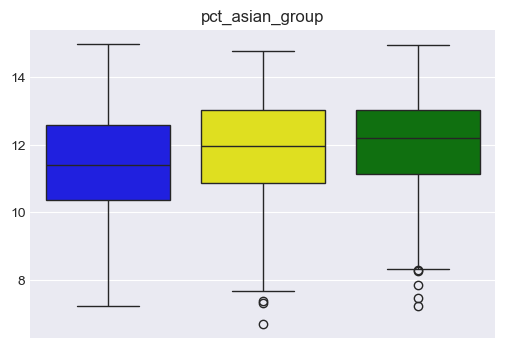

In [1503]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='asian_group', y='log_distance', data=combined_data_asian, palette=asian_palette,hue='asian_group')
plt.title('pct_asian_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_asian_group_dt.png',dpi=300)

## 35_ unemployment

In [1504]:
merged_unemp_dt = merged_df[['FIPS','pct_unemp','distance_from_home']]
merged_unemp_ranked = merged_unemp_dt.sort_values('pct_unemp')

In [1505]:
pct_low_unemp = merged_unemp_ranked.head(1267)
pct_moderate_unemp = merged_unemp_ranked.iloc[1267:2535]
pct_high_unemp= merged_unemp_ranked.iloc[2536:3804]

In [1506]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_unemp_dt = pct_low_unemp['distance_from_home'].mean()
pct_mean_visits_moderate_unemp_dt = pct_moderate_unemp['distance_from_home'].mean()
pct_mean_visits_high_unemp_dt = pct_high_unemp['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_unemp: {pct_mean_visits_low_unemp_dt}')
print(f'Mean travel distance for pct_moderate_unemp: {pct_mean_visits_moderate_unemp_dt}')
print(f'Mean travel distance for pct_high_unemp: {pct_mean_visits_high_unemp_dt}')

Mean travel distance for pct_low_unemp: 337305.01973164955
Mean travel distance for pct_moderate_unemp: 323210.9826498423
Mean travel distance for pct_high_unemp: 279443.7066246057


In [1507]:
# perform One_way ANOVA

anova_result_unemp = f_oneway(pct_low_unemp['distance_from_home'], pct_moderate_unemp['distance_from_home'],pct_high_unemp['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_unemp.statistic}")
print(f"ANOVA p-value: {anova_result_unemp.pvalue}")

ANOVA F-value: 7.2923478045158525
ANOVA p-value: 0.0006902965913781749


In [1508]:
# Step 1: Combine data into a single DataFrame
combined_data_unemp = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_unemp['distance_from_home'], 
        pct_moderate_unemp['distance_from_home'], 
        pct_high_unemp['distance_from_home']
    ], ignore_index=True),
    'unemp_group': ['pct_low_unemp'] * len(pct_low_unemp) + 
                    ['pct_moderate_unemp'] * len(pct_moderate_unemp) + 
                    ['pct_high_unemp'] * len(pct_high_unemp)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_unemp['distance_from_home'],
                                  groups=combined_data_unemp['unemp_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1           group2         meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------------------
pct_high_unemp      pct_low_unemp  57861.3131 0.0007  20811.0208 94911.6055   True
pct_high_unemp pct_moderate_unemp   43767.276 0.0155   6724.2922 80810.2599   True
 pct_low_unemp pct_moderate_unemp -14094.0371 0.6455 -51144.3294 22956.2553  False
----------------------------------------------------------------------------------


In [1509]:
# Apply log transformation to the visits_by_cbg column
combined_data_unemp['log_distance'] = np.log(combined_data_unemp['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
unemp_palette = {'pct_low_unemp': 'blue', 'pct_moderate_unemp': 'yellow', 'pct_high_unemp': 'green'}

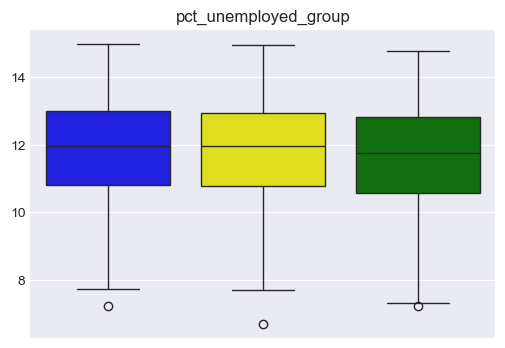

In [1510]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='unemp_group', y='log_distance', data=combined_data_unemp, palette=unemp_palette,hue='unemp_group')
plt.title('pct_unemployed_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_unemployed_group_dt.png',dpi=300)

## 36) Female

In [1511]:
merged_female_dt = merged_df[['FIPS','pct_female','distance_from_home']]
merged_female_ranked = merged_female_dt.sort_values('pct_female')

In [1512]:
pct_low_female = merged_female_ranked.head(1267)
pct_moderate_female = merged_female_ranked.iloc[1267:2535]
pct_high_female = merged_female_ranked.iloc[2536:3804]

In [1513]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_female_dt = pct_low_female['distance_from_home'].mean()
pct_mean_visits_moderate_female_dt = pct_moderate_female['distance_from_home'].mean()
pct_mean_visits_high_female_dt = pct_high_female['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_female: {pct_mean_visits_low_female_dt}')
print(f'Mean travel distance for pct_moderate_female: {pct_mean_visits_moderate_female_dt}')
print(f'Mean travel distance for pct_high_female: {pct_mean_visits_high_female_dt}')

Mean travel distance for pct_low_female: 317912.71112865035
Mean travel distance for pct_moderate_female: 301572.07018927444
Mean travel distance for pct_high_female: 320010.9211356467


In [1514]:
# perform One_way ANOVA

anova_result_female = f_oneway(pct_low_female['distance_from_home'], pct_moderate_female['distance_from_home'],pct_high_female['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_female.statistic}")
print(f"ANOVA p-value: {anova_result_female.pvalue}")

ANOVA F-value: 0.8136589073984188
ANOVA p-value: 0.443310551277017


In [1515]:
# Step 1: Combine data into a single DataFrame
combined_data_female = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_female['distance_from_home'], 
        pct_moderate_female['distance_from_home'], 
        pct_high_female['distance_from_home']
    ], ignore_index=True),
    'female_group': ['pct_low_female'] * len(pct_low_female) + 
                    ['pct_moderate_female'] * len(pct_moderate_female) + 
                    ['pct_high_female'] * len(pct_high_female)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_female['distance_from_home'],
                                  groups=combined_data_female['female_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
     group1            group2         meandiff  p-adj     lower      upper    reject
------------------------------------------------------------------------------------
pct_high_female      pct_low_female    -2098.21 0.9904 -39211.0298 35014.6098  False
pct_high_female pct_moderate_female -18438.8509 0.4742   -55544.35 18666.6481  False
 pct_low_female pct_moderate_female -16340.6409 0.5565 -53453.4608 20772.1789  False
------------------------------------------------------------------------------------


In [1516]:
# Apply log transformation to the visits_by_cbg column
combined_data_female['log_distance'] = np.log(combined_data_female['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
female_palette = {'pct_low_female': 'blue', 'pct_moderate_female': 'yellow', 'pct_high_female': 'green'}


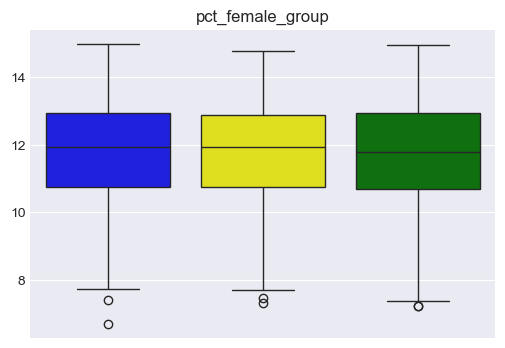

In [1517]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='female_group', y='log_distance', data=combined_data_female, palette=female_palette,hue='female_group')
plt.title('pct_female_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_female_group_dt.png',dpi=300)

## 37) Age: Young

In [1518]:
merged_young_dt = merged_df[['FIPS','pct_young','distance_from_home']]
merged_young_ranked = merged_young_dt.sort_values('pct_young')

In [1519]:
pct_low_young = merged_young_ranked.head(1267)
pct_moderate_young = merged_young_ranked.iloc[1267:2535]
pct_high_young = merged_young_ranked.iloc[2536:3804]

In [1520]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_young_dt = pct_low_young['distance_from_home'].mean()
pct_mean_visits_moderate_young_dt = pct_moderate_young['distance_from_home'].mean()
pct_mean_visits_high_young_dt = pct_high_young['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_young: {pct_mean_visits_low_young_dt}')
print(f'Mean travel distance for pct_moderate_young: {pct_mean_visits_moderate_young_dt}')
print(f'Mean travel distance for pct_high_young: {pct_mean_visits_high_young_dt}')

Mean travel distance for pct_low_young: 325379.3685872139
Mean travel distance for pct_moderate_young: 274275.45110410097
Mean travel distance for pct_high_young: 340312.856466877


In [1521]:
# perform One_way ANOVA

anova_result_young = f_oneway(pct_low_young['distance_from_home'], pct_moderate_young['distance_from_home'],pct_high_young['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_young.statistic}")
print(f"ANOVA p-value: {anova_result_young.pvalue}")

ANOVA F-value: 9.620431777413494
ANOVA p-value: 6.798947075831131e-05


In [1522]:
# Step 1: Combine data into a single DataFrame
combined_data_young = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_young['distance_from_home'], 
        pct_moderate_young['distance_from_home'], 
        pct_high_young['distance_from_home']
    ], ignore_index=True),
    'young_group': ['pct_low_young'] * len(pct_low_young) + 
                    ['pct_moderate_young'] * len(pct_moderate_young) + 
                    ['pct_high_young'] * len(pct_high_young)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_young['distance_from_home'],
                                  groups=combined_data_young['young_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
    group1           group2         meandiff  p-adj     lower        upper    reject
------------------------------------------------------------------------------------
pct_high_young      pct_low_young -14933.4879 0.6114  -51960.8109  22093.8352  False
pct_high_young pct_moderate_young -66037.4054 0.0001 -103057.4245 -29017.3862   True
 pct_low_young pct_moderate_young -51103.9175 0.0035  -88131.2405 -14076.5944   True
------------------------------------------------------------------------------------


In [1523]:
# Apply log transformation to the visits_by_cbg column
combined_data_young['log_distance'] = np.log(combined_data_young['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
young_palette = {'pct_low_young': 'blue', 'pct_moderate_young': 'yellow', 'pct_high_young': 'green'}

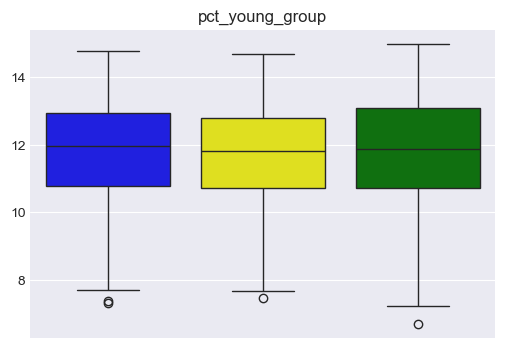

In [1524]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='young_group', y='log_distance', data=combined_data_young, palette=young_palette,hue='young_group')
plt.title('pct_young_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_young_group_dt.png',dpi=300)

## 38) Age: Adult

In [1525]:
merged_adult_dt = merged_df[['FIPS','pct_adult','distance_from_home']]
merged_adult_ranked = merged_adult_dt.sort_values('pct_adult')

In [1526]:
pct_low_adult = merged_adult_ranked.head(1267)
pct_moderate_adult = merged_adult_ranked.iloc[1267:2535]
pct_high_adult = merged_adult_ranked.iloc[2536:3804]

In [1527]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_adult_dt = pct_low_adult['distance_from_home'].mean()
pct_mean_visits_moderate_adult_dt = pct_moderate_adult['distance_from_home'].mean()
pct_mean_visits_high_adult_dt = pct_high_adult['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_adult: {pct_mean_visits_low_adult_dt}')
print(f'Mean travel distance for pct_moderate_adult: {pct_mean_visits_moderate_adult_dt}')
print(f'Mean travel distance for pct_high_adult: {pct_mean_visits_high_adult_dt}')

Mean travel distance for pct_low_adult: 332254.363851618
Mean travel distance for pct_moderate_adult: 306652.7310725552
Mean travel distance for pct_high_adult: 301074.7539432177


In [1529]:
# perform One_way ANOVA

anova_result_adult = f_oneway(pct_low_adult['distance_from_home'], pct_moderate_adult['distance_from_home'],pct_high_adult['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_adult.statistic}")
print(f"ANOVA p-value: {anova_result_adult.pvalue}")

ANOVA F-value: 2.2081014728755353
ANOVA p-value: 0.11005011962849713


In [1530]:
# Step 1: Combine data into a single DataFrame
combined_data_adult = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_adult['distance_from_home'], 
        pct_moderate_adult['distance_from_home'], 
        pct_high_adult['distance_from_home']
    ], ignore_index=True),
    'adult_group': ['pct_low_adult'] * len(pct_low_adult) + 
                    ['pct_moderate_adult'] * len(pct_moderate_adult) + 
                    ['pct_high_adult'] * len(pct_high_adult)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_adult['distance_from_home'],
                                  groups=combined_data_adult['adult_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
    group1           group2         meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------------------
pct_high_adult      pct_low_adult  31179.6099 0.1197  -5919.5832  68278.803  False
pct_high_adult pct_moderate_adult   5577.9771 0.9338 -31513.8979 42669.8521  False
 pct_low_adult pct_moderate_adult -25601.6328 0.2381 -62700.8259 11497.5603  False
----------------------------------------------------------------------------------


In [1531]:
# Apply log transformation to the visits_by_cbg column
combined_data_adult['log_distance'] = np.log(combined_data_adult['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
adult_palette = {'pct_low_adult': 'blue', 'pct_moderate_adult': 'yellow', 'pct_high_adult': 'green'}

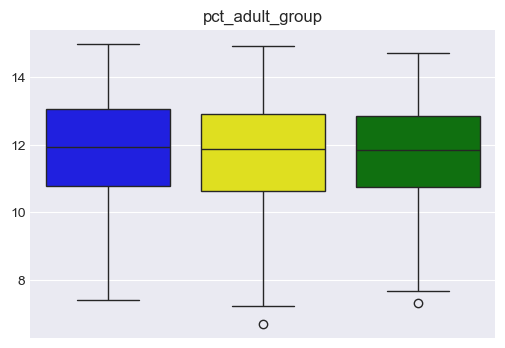

In [1532]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='adult_group', y='log_distance', data=combined_data_adult, palette=adult_palette,hue='adult_group')
plt.title('pct_adult_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_adult_group_dt.png',dpi=300)

## 39) Age: Elderly

In [1533]:
merged_elderly_dt = merged_df[['FIPS','pct_elderly','distance_from_home']]
merged_elderly_ranked = merged_elderly_dt.sort_values('pct_elderly')

In [1534]:
pct_low_elderly = merged_elderly_ranked.head(1267)
pct_moderate_elderly = merged_elderly_ranked.iloc[1267:2535]
pct_high_elderly = merged_elderly_ranked.iloc[2535:3804]

In [1535]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_elderly_dt = pct_low_elderly['distance_from_home'].mean()
pct_mean_visits_moderate_elderly_dt = pct_moderate_elderly['distance_from_home'].mean()
pct_mean_visits_high_elderly_dt = pct_high_elderly['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_elderly: {pct_mean_visits_low_elderly_dt}')
print(f'Mean travel distance for pct_moderate_elderly: {pct_mean_visits_moderate_elderly_dt}')
print(f'Mean travel distance for pct_high_elderly: {pct_mean_visits_high_elderly_dt}')

Mean travel distance for pct_low_elderly: 336762.2580899763
Mean travel distance for pct_moderate_elderly: 285905.380126183
Mean travel distance for pct_high_elderly: 317076.8731284476


In [1536]:
# perform One_way ANOVA

anova_result_elderly = f_oneway(pct_low_elderly['distance_from_home'], pct_moderate_elderly['distance_from_home'],pct_high_elderly['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_elderly.statistic}")
print(f"ANOVA p-value: {anova_result_elderly.pvalue}")

ANOVA F-value: 5.262407260454788
ANOVA p-value: 0.005220641531585309


In [1537]:
# Step 1: Combine data into a single DataFrame
combined_data_elderly = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_elderly['distance_from_home'], 
        pct_moderate_elderly['distance_from_home'], 
        pct_high_elderly['distance_from_home']
    ], ignore_index=True),
    'elderly_group': ['pct_low_elderly'] * len(pct_low_elderly) + 
                    ['pct_moderate_elderly'] * len(pct_moderate_elderly) + 
                    ['pct_high_elderly'] * len(pct_high_elderly)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_elderly['distance_from_home'],
                                  groups=combined_data_elderly['elderly_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
     group1             group2         meandiff  p-adj     lower       upper    reject
--------------------------------------------------------------------------------------
pct_high_elderly      pct_low_elderly  19685.385 0.4265 -17374.6858  56745.4557  False
pct_high_elderly pct_moderate_elderly -31171.493 0.1192 -68224.2505   5881.2645  False
 pct_low_elderly pct_moderate_elderly -50856.878 0.0037  -87924.249 -13789.5069   True
--------------------------------------------------------------------------------------


In [1538]:
# Apply log transformation to the visits_by_cbg column
combined_data_elderly['log_distance'] = np.log(combined_data_elderly['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
elderly_palette = {'pct_low_elderly': 'blue', 'pct_moderate_elderly': 'yellow', 'pct_high_elderly': 'green'}

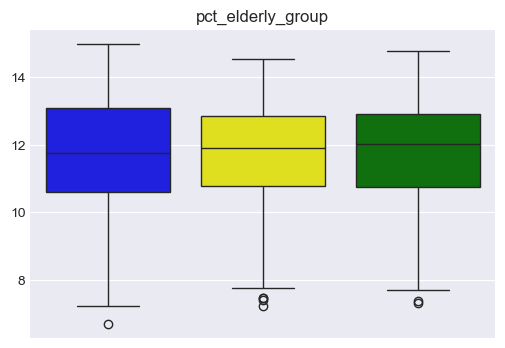

In [1539]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='elderly_group', y='log_distance', data=combined_data_elderly, palette=elderly_palette,hue='elderly_group')
plt.title('pct_elderly_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_elderly_group_dt.png',dpi=300)

## 40) Education: Less High

In [1540]:
merged_lessHigh_dt = merged_df[['FIPS','pct_low_edu','distance_from_home']]
merged_lessHigh_ranked = merged_lessHigh_dt.sort_values('pct_low_edu')

In [1541]:
pct_low_lessHigh = merged_lessHigh_ranked.head(1267)
pct_moderate_lessHigh = merged_lessHigh_ranked.iloc[1267:2535]
pct_high_lessHigh = merged_lessHigh_ranked.iloc[2536:3804]

In [1542]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_lessHigh_dt = pct_low_lessHigh['distance_from_home'].mean()
pct_mean_visits_moderate_lessHigh_dt = pct_moderate_lessHigh['distance_from_home'].mean()
pct_mean_visits_high_lessHigh_dt = pct_high_lessHigh['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_lessHigh: {pct_mean_visits_low_lessHigh_dt}')
print(f'Mean travel distance for pct_moderate_lessHigh: {pct_mean_visits_moderate_lessHigh_dt}')
print(f'Mean travel distance for pct_high_lessHigh: {pct_mean_visits_high_lessHigh_dt}')

Mean travel distance for pct_low_lessHigh: 406727.36621941597
Mean travel distance for pct_moderate_lessHigh: 254593.92034700315
Mean travel distance for pct_high_lessHigh: 278690.2720820189


In [1543]:
# perform One_way ANOVA

anova_result_lessHigh = f_oneway(pct_low_lessHigh['distance_from_home'], pct_moderate_lessHigh['distance_from_home'],pct_high_lessHigh['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_lessHigh.statistic}")
print(f"ANOVA p-value: {anova_result_lessHigh.pvalue}")

ANOVA F-value: 54.88299634132556
ANOVA p-value: 3.1796585823921272e-24


In [1544]:
# Step 1: Combine data into a single DataFrame
combined_data_lessHigh = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_lessHigh['distance_from_home'], 
        pct_moderate_lessHigh['distance_from_home'], 
        pct_high_lessHigh['distance_from_home']
    ], ignore_index=True),
    'lessHigh_group': ['pct_low_lessHigh'] * len(pct_low_lessHigh) + 
                    ['pct_moderate_lessHigh'] * len(pct_moderate_lessHigh) + 
                    ['pct_high_lessHigh'] * len(pct_high_lessHigh)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_lessHigh['distance_from_home'],
                                  groups=combined_data_lessHigh['lessHigh_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
      group1              group2          meandiff   p-adj     lower        upper     reject
--------------------------------------------------------------------------------------------
pct_high_lessHigh      pct_low_lessHigh  128037.0941    0.0   91440.5064  164633.6818   True
pct_high_lessHigh pct_moderate_lessHigh  -24096.3517 0.2705  -60685.7205    12493.017  False
 pct_low_lessHigh pct_moderate_lessHigh -152133.4459    0.0 -188730.0336 -115536.8582   True
--------------------------------------------------------------------------------------------


In [1545]:
# Apply log transformation to the visits_by_cbg column
combined_data_lessHigh['log_distance'] = np.log(combined_data_lessHigh['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
lessHigh_palette = {'pct_low_lessHigh': 'blue', 'pct_moderate_lessHigh': 'yellow', 'pct_high_lessHigh': 'green'}

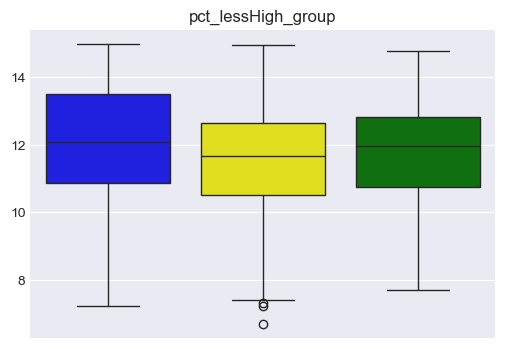

In [1546]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='lessHigh_group', y='log_distance', data=combined_data_lessHigh, palette=lessHigh_palette,hue='lessHigh_group')
plt.title('pct_lessHigh_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_lessHigh_group_dt.png',dpi=300)

## 41) Education: High Sch

In [1547]:
merged_highsch_dt = merged_df[['FIPS','pct_high_edu','distance_from_home']]
merged_highsch_ranked = merged_highsch_dt.sort_values('pct_high_edu')

In [1548]:
pct_low_highsch = merged_highsch_ranked.head(1267)
pct_moderate_highsch = merged_highsch_ranked.iloc[1267:2535]
pct_high_highsch = merged_highsch_ranked.iloc[2536:3804]

In [1549]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_High_dt = pct_low_highsch['distance_from_home'].mean()
pct_mean_visits_moderate_High_dt = pct_moderate_highsch['distance_from_home'].mean()
pct_mean_visits_high_High_dt = pct_high_highsch['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_High: {pct_mean_visits_low_High_dt}')
print(f'Mean travel distance for pct_moderate_High: {pct_mean_visits_moderate_High_dt}')
print(f'Mean travel distance for pct_high_High: {pct_mean_visits_high_High_dt}')

Mean travel distance for pct_low_High: 278653.9471191792
Mean travel distance for pct_moderate_High: 254638.46687697162
Mean travel distance for pct_high_High: 406476.0512618297


In [1550]:
# perform One_way ANOVA

anova_result_highsch = f_oneway(pct_low_highsch['distance_from_home'], pct_moderate_highsch['distance_from_home'],pct_high_highsch['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_highsch.statistic}")
print(f"ANOVA p-value: {anova_result_highsch.pvalue}")

ANOVA F-value: 54.69262772798534
ANOVA p-value: 3.8259503139214756e-24


In [1551]:
# Step 1: Combine data into a single DataFrame
combined_data_highsch = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_highsch['distance_from_home'], 
        pct_moderate_highsch['distance_from_home'], 
        pct_high_highsch['distance_from_home']
    ], ignore_index=True),
    'highsch_group': ['pct_low_highsch'] * len(pct_low_highsch) + 
                    ['pct_moderate_highsch'] * len(pct_moderate_highsch) + 
                    ['pct_high_highsch'] * len(pct_high_highsch)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_highsch['distance_from_home'],
                                  groups=combined_data_highsch['highsch_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
     group1             group2          meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------------------------------
pct_high_highsch      pct_low_highsch -127822.1041   0.0 -164422.3829  -91221.8254   True
pct_high_highsch pct_moderate_highsch -151837.5844   0.0 -188430.6435 -115244.5253   True
 pct_low_highsch pct_moderate_highsch  -24015.4802 0.273   -60615.759   12584.7985  False
-----------------------------------------------------------------------------------------


In [1552]:
# Apply log transformation to the visits_by_cbg column
combined_data_highsch['log_distance'] = np.log(combined_data_highsch['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
highsch_palette = {'pct_low_highsch': 'blue', 'pct_moderate_highsch': 'yellow', 'pct_high_highsch': 'green'}

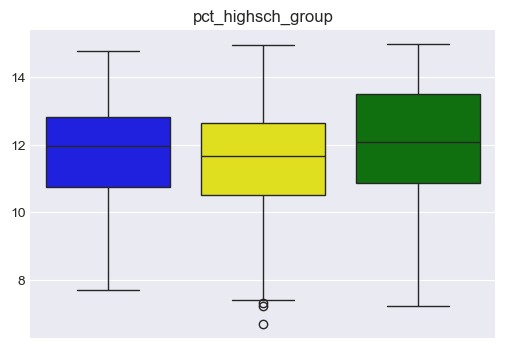

In [1553]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='highsch_group', y='log_distance', data=combined_data_highsch, palette=highsch_palette,hue='highsch_group')
plt.title('pct_highsch_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_highsch_group_dt.png',dpi=300)

## 42 Transport: Car

In [1554]:
merged_car_dt = merged_df[['FIPS','pct_car','distance_from_home']]
merged_car_ranked = merged_car_dt.sort_values('pct_car')

In [1555]:
pct_low_car = merged_car_ranked.head(1267)
pct_moderate_car = merged_car_ranked.iloc[1267:2535]
pct_high_car = merged_car_ranked.iloc[2536:3804]

In [1556]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_car_dt = pct_low_car['distance_from_home'].mean()
pct_mean_visits_moderate_car_dt = pct_moderate_car['distance_from_home'].mean()
pct_mean_visits_high_car_dt = pct_high_car['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_car: {pct_mean_visits_low_car_dt}')
print(f'Mean travel distance for pct_moderate_car: {pct_mean_visits_moderate_car_dt}')
print(f'Mean travel distance for pct_high_car: {pct_mean_visits_high_car_dt}')

Mean travel distance for pct_low_car: 467608.93685872137
Mean travel distance for pct_moderate_car: 271959.4503154574
Mean travel distance for pct_high_car: 200376.6979495268


In [1557]:
# perform One_way ANOVA

anova_result_car = f_oneway(pct_low_car['distance_from_home'], pct_moderate_car['distance_from_home'],pct_high_car['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_car.statistic}")
print(f"ANOVA p-value: {anova_result_car.pvalue}")

ANOVA F-value: 165.9851952674714
ANOVA p-value: 7.765191787379126e-70


In [1558]:
# Step 1: Combine data into a single DataFrame
combined_data_car = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_car['distance_from_home'], 
        pct_moderate_car['distance_from_home'], 
        pct_high_car['distance_from_home']
    ], ignore_index=True),
    'car_group': ['pct_low_car'] * len(pct_low_car) + 
                    ['pct_moderate_car'] * len(pct_moderate_car) + 
                    ['pct_high_car'] * len(pct_high_car)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_car['distance_from_home'],
                                  groups=combined_data_car['car_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
   group1         group2        meandiff   p-adj    lower        upper     reject
---------------------------------------------------------------------------------
pct_high_car      pct_low_car  267232.2389   0.0  231631.6276  302832.8503   True
pct_high_car pct_moderate_car   71582.7524   0.0   35989.1635  107176.3412   True
 pct_low_car pct_moderate_car -195649.4865   0.0 -231250.0979 -160048.8752   True
---------------------------------------------------------------------------------


In [1559]:
# Apply log transformation to the visits_by_cbg column
combined_data_car['log_distance'] = np.log(combined_data_car['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
car_palette = {'pct_low_car': 'blue', 'pct_moderate_car': 'yellow', 'pct_high_car': 'green'}

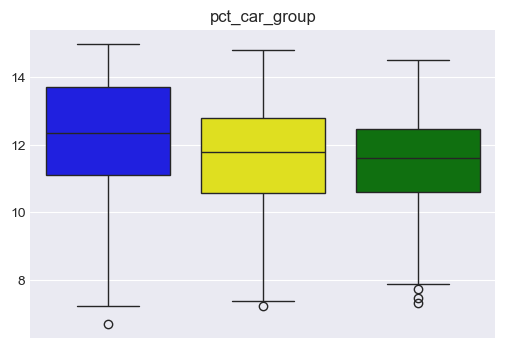

In [1560]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='car_group', y='log_distance', data=combined_data_car, palette=car_palette,hue='car_group')
plt.title('pct_car_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_car_group_dt.png',dpi=300)

## 43) Transport: 0car

In [1561]:
merged_0car_dt = merged_df[['FIPS','pct_0car','distance_from_home']]
merged_0car_ranked = merged_0car_dt.sort_values('pct_0car')

In [1562]:
pct_low_0car = merged_0car_ranked.head(1267)
pct_moderate_0car = merged_0car_ranked.iloc[1267:2535]
pct_high_0car = merged_0car_ranked.iloc[1267:2535]

In [1563]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_0car_dt = pct_low_0car['distance_from_home'].mean()
pct_mean_visits_moderate_0car_dt = pct_moderate_0car['distance_from_home'].mean()
pct_mean_visits_high_0car_dt = pct_high_0car['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_0car: {pct_mean_visits_low_0car_dt}')
print(f'Mean travel distance for pct_moderate_0car: {pct_mean_visits_moderate_0car_dt}')
print(f'Mean travel distance for pct_high_0car: {pct_mean_visits_high_0car_dt}')

Mean travel distance for pct_low_0car: 216507.2991318074
Mean travel distance for pct_moderate_0car: 266493.65851735015
Mean travel distance for pct_high_0car: 266493.65851735015


In [1564]:
# perform One_way ANOVA

anova_result_0car = f_oneway(pct_low_0car['distance_from_home'], pct_moderate_0car['distance_from_home'],pct_high_0car['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_0car.statistic}")
print(f"ANOVA p-value: {anova_result_0car.pvalue}")

ANOVA F-value: 10.440874950118339
ANOVA p-value: 3.0060688197277144e-05


In [1565]:
# Step 1: Combine data into a single DataFrame
combined_data_0car = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_0car['distance_from_home'], 
        pct_moderate_0car['distance_from_home'], 
        pct_high_0car['distance_from_home']
    ], ignore_index=True),
    '0car_group': ['pct_low_0car'] * len(pct_low_0car) + 
                    ['pct_moderate_0car'] * len(pct_moderate_0car) + 
                    ['pct_high_0car'] * len(pct_high_0car)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_0car['distance_from_home'],
                                  groups=combined_data_0car['0car_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
    group1          group2        meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------------------------
pct_high_0car      pct_low_0car -49986.3594 0.0002 -79599.3016 -20373.4171   True
pct_high_0car pct_moderate_0car         0.0    1.0 -29607.1009  29607.1009  False
 pct_low_0car pct_moderate_0car  49986.3594 0.0002  20373.4171  79599.3016   True
---------------------------------------------------------------------------------


In [1566]:
# Apply log transformation to the visits_by_cbg column
combined_data_0car['log_distance'] = np.log(combined_data_0car['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Zcar_palette = {'pct_low_0car': 'blue', 'pct_moderate_0car': 'yellow', 'pct_high_0car': 'green'}

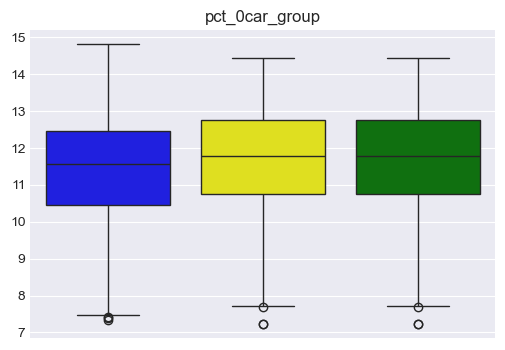

In [1567]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='0car_group', y='log_distance', data=combined_data_0car, palette=Zcar_palette,hue='0car_group')
plt.title('pct_0car_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_0car_group_dt.png',dpi=300)

## 44: Transport: Public Transit

In [1568]:
merged_public_trans_dt = merged_df[['FIPS','pct_public_trans','distance_from_home']]
merged_public_trans_ranked = merged_public_trans_dt.sort_values('pct_public_trans')

In [1569]:
pct_low_public_trans = merged_public_trans_ranked.head(1267)
pct_moderate_public_trans = merged_public_trans_ranked.iloc[1267:2535]
pct_high_public_trans = merged_public_trans_ranked.iloc[2536:3804]

In [1570]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_publictrans_dt = pct_low_public_trans['distance_from_home'].mean()
pct_mean_visits_moderate_publictrans_dt = pct_moderate_public_trans['distance_from_home'].mean()
pct_mean_visits_high_publictrans_dt = pct_high_public_trans['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_publictrans: {pct_mean_visits_low_publictrans_dt}')
print(f'Mean travel distance for pct_moderate_publictrans: {pct_mean_visits_moderate_publictrans_dt}')
print(f'Mean travel distance for pct_high_publictrans: {pct_mean_visits_high_publictrans_dt}')

Mean travel distance for pct_low_publictrans: 271322.2304656669
Mean travel distance for pct_moderate_publictrans: 339865.4093059937
Mean travel distance for pct_high_publictrans: 328025.84148264985


In [1571]:
# perform One_way ANOVA

anova_result_public_trans = f_oneway(pct_low_public_trans['distance_from_home'], pct_moderate_public_trans['distance_from_home'],pct_high_public_trans['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_public_trans.statistic}")
print(f"ANOVA p-value: {anova_result_public_trans.pvalue}")

ANOVA F-value: 10.774363867362858
ANOVA p-value: 2.1575984719786973e-05


In [1572]:
# Step 1: Combine data into a single DataFrame
combined_data_public_trans = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_public_trans['distance_from_home'], 
        pct_moderate_public_trans['distance_from_home'], 
        pct_high_public_trans['distance_from_home']
    ], ignore_index=True),
    'public_trans_group': ['pct_low_public_trans'] * len(pct_low_public_trans) + 
                    ['pct_moderate_public_trans'] * len(pct_moderate_public_trans) + 
                    ['pct_high_public_trans'] * len(pct_high_public_trans)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_public_trans['distance_from_home'],
                                  groups=combined_data_public_trans['public_trans_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
        group1                  group2           meandiff  p-adj     lower       upper    reject
------------------------------------------------------------------------------------------------
pct_high_public_trans      pct_low_public_trans -56703.611  0.001 -93710.8626 -19696.3595   True
pct_high_public_trans pct_moderate_public_trans 11839.5678 0.7335 -25160.3838  48839.5194  False
 pct_low_public_trans pct_moderate_public_trans 68543.1788    0.0  31535.9273 105550.4304   True
------------------------------------------------------------------------------------------------


In [1573]:
# Apply log transformation to the visits_by_cbg column
combined_data_public_trans['log_distance'] = np.log(combined_data_public_trans['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
public_trans_palette = {'pct_low_public_trans': 'blue', 'pct_moderate_public_trans': 'yellow', 'pct_high_public_trans': 'green'}

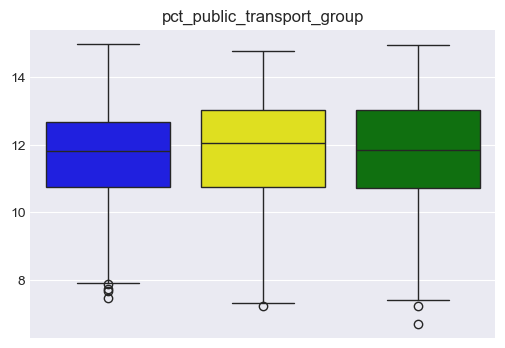

In [1574]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='public_trans_group', y='log_distance', data=combined_data_public_trans, palette=public_trans_palette,hue='public_trans_group')
plt.title('pct_public_transport_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_public_trans_group_dt.png',dpi=300)

## 45) Commute: Short

In [1575]:
merged_short_commute_dt = merged_df[['FIPS','pct_short_comute','distance_from_home']]
merged_short_commute_ranked = merged_short_commute_dt.sort_values('pct_short_comute')

In [1576]:
pct_low_Scomute = merged_short_commute_ranked.head(1267)
pct_moderate_Scomute = merged_short_commute_ranked.iloc[1267:2535]
pct_high_Scomute = merged_short_commute_ranked.iloc[2536:3804]

In [1577]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_Scommute_dt = pct_low_Scomute['distance_from_home'].mean()
pct_mean_visits_moderate_Scommute_dt = pct_moderate_Scomute['distance_from_home'].mean()
pct_mean_visits_high_Scommute_dt = pct_high_Scomute['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_Scommute: {pct_mean_visits_low_Scommute_dt}')
print(f'Mean travel distance for pct_moderate_Scommute: {pct_mean_visits_moderate_Scommute_dt}')
print(f'Mean travel distance for pct_high_Scommute: {pct_mean_visits_high_Scommute_dt}')

Mean travel distance for pct_low_Scommute: 208009.94711917915
Mean travel distance for pct_moderate_Scommute: 246665.86514195584
Mean travel distance for pct_high_Scommute: 484398.14826498425


In [1578]:
# perform One_way ANOVA

anova_result_Scomute = f_oneway(pct_low_Scomute['distance_from_home'], pct_moderate_Scomute['distance_from_home'],pct_high_Scomute['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_Scomute.statistic}")
print(f"ANOVA p-value: {anova_result_Scomute.pvalue}")

ANOVA F-value: 197.4879214058281
ANOVA p-value: 2.5284333438013803e-82


In [1579]:
# Step 1: Combine data into a single DataFrame
combined_data_Scomute = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_Scomute['distance_from_home'], 
        pct_moderate_Scomute['distance_from_home'], 
        pct_high_Scomute['distance_from_home']
    ], ignore_index=True),
    'Scomute_group': ['pct_low_Scomute'] * len(pct_low_Scomute) + 
                    ['pct_moderate_Scomute'] * len(pct_moderate_Scomute) + 
                    ['pct_high_Scomute'] * len(pct_high_Scomute)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_Scomute['distance_from_home'],
                                  groups=combined_data_Scomute['Scomute_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
     group1             group2          meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------------------------
pct_high_Scomute      pct_low_Scomute -276388.2011    0.0 -311705.4703  -241070.932   True
pct_high_Scomute pct_moderate_Scomute -237732.2831    0.0 -273042.5857 -202421.9806   True
 pct_low_Scomute pct_moderate_Scomute    38655.918 0.0278    3338.6489   73973.1872   True
------------------------------------------------------------------------------------------


In [1580]:
# Apply log transformation to the visits_by_cbg column
combined_data_Scomute['log_distance'] = np.log(combined_data_Scomute['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Scomute_palette = {'pct_low_Scomute': 'blue', 'pct_moderate_Scomute': 'yellow', 'pct_high_Scomute': 'green'}

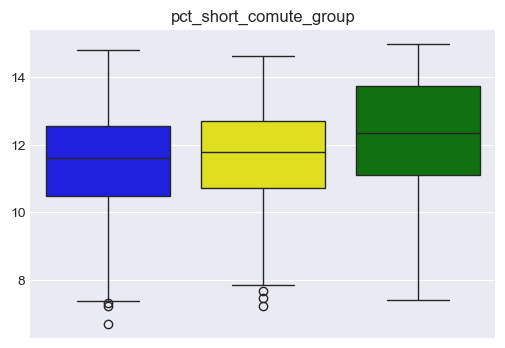

In [1581]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='Scomute_group', y='log_distance', data=combined_data_Scomute, palette=Scomute_palette,hue='Scomute_group')
plt.title('pct_short_comute_group')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.savefig('pct_Scomute_group_dt.png',dpi=300)

## 46) Commute: Long

In [1582]:
merged_Lcomute_dt = merged_df[['FIPS','pct_long_comute','distance_from_home']]
merged_Lcomute_ranked = merged_Lcomute_dt.sort_values('pct_long_comute')

In [1583]:
pct_low_Lcomute = merged_Lcomute_ranked.head(1267)
pct_moderate_Lcomute =merged_Lcomute_ranked.iloc[1267:2535]
pct_high_Lcomute = merged_Lcomute_ranked.iloc[2536:3804]

In [1584]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_Lcommute_dt = pct_low_Lcomute['distance_from_home'].mean()
pct_mean_visits_moderate_Lcommute_dt = pct_moderate_Lcomute['distance_from_home'].mean()
pct_mean_visits_high_Lcommute_dt = pct_high_Lcomute['distance_from_home'].mean()

print(f'Mean travel distance for pct_low_Lcommute: {pct_mean_visits_low_Lcommute_dt}')
print(f'Mean travel distance for pct_moderate_Lcommute: {pct_mean_visits_moderate_Lcommute_dt}')
print(f'Mean travel distance for pct_high_Lcommute: {pct_mean_visits_high_Lcommute_dt}')

Mean travel distance for pct_low_Lcommute: 484729.36543014995
Mean travel distance for pct_moderate_Lcommute: 247071.45504731862
Mean travel distance for pct_high_Lcommute: 208053.70347003156


In [1585]:
# perform One_way ANOVA

anova_result_Lcomute = f_oneway(pct_low_Lcomute['distance_from_home'], pct_moderate_Lcomute['distance_from_home'],pct_high_Lcomute['distance_from_home'])

# Print the results
print(f"ANOVA F-value: {anova_result_Lcomute.statistic}")
print(f"ANOVA p-value: {anova_result_Lcomute.pvalue}")

ANOVA F-value: 197.47345269776707
ANOVA p-value: 2.5617902706872476e-82


In [1586]:
# Step 1: Combine data into a single DataFrame
combined_data_Lcomute = pd.DataFrame({
    'distance_from_home': pd.concat([
        pct_low_Lcomute['distance_from_home'], 
        pct_moderate_Lcomute['distance_from_home'], 
        pct_high_Lcomute['distance_from_home']
    ], ignore_index=True),
    'Lcomute_group': ['pct_low_Lcomute'] * len(pct_low_Lcomute) + 
                    ['pct_moderate_Lcomute'] * len(pct_moderate_Lcomute) + 
                    ['pct_high_Lcomute'] * len(pct_high_Lcomute)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data_Lcomute['distance_from_home'],
                                  groups=combined_data_Lcomute['Lcomute_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
     group1             group2          meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------------------------
pct_high_Lcomute      pct_low_Lcomute   276675.662    0.0  241342.8731  312008.4508   True
pct_high_Lcomute pct_moderate_Lcomute   39017.7516 0.0261    3691.9324   74343.5707   True
 pct_low_Lcomute pct_moderate_Lcomute -237657.9104    0.0 -272990.6992 -202325.1216   True
------------------------------------------------------------------------------------------


In [1587]:
# Apply log transformation to the visits_by_cbg column
combined_data_Lcomute['log_distance'] = np.log(combined_data_Lcomute['distance_from_home'] + 1)  # Adding 1 to avoid log(0)

# Define a color palette for each income group
Lcomute_palette = {'pct_low_Lcomute': 'blue', 'pct_moderate_Lcomute': 'yellow', 'pct_high_Lcomute': 'green'}

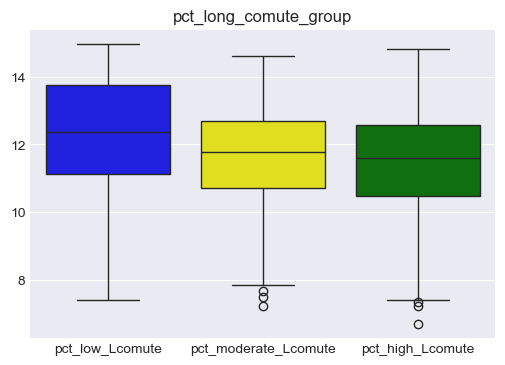

In [1588]:
# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 4))
sns.boxplot(x='Lcomute_group', y='log_distance', data=combined_data_Lcomute, palette=Lcomute_palette,hue='Lcomute_group')
plt.title('pct_long_comute_group')
plt.xlabel('')
plt.ylabel('')

plt.savefig('pct_Lcommute_group_dt.png',dpi=300)